In [2]:
%load_ext autoreload
%autoreload 2   # Change to %autoreload when development phase is over

# Table of Contents

<div id="toc"></div>

The following cell is a Javascript section of code for building the Jupyter notebook's table of content.

In [3]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

**-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-**

# Define working environment

**Import libraries**

In [4]:
## Import libraries needed for setting parameters of operating system 
import os
import sys
## Import library for temporary files creation 
import tempfile 
## Import library for time management 
import time
## Import multiprocessing and functools libraries
import multiprocessing
from multiprocessing import Pool
from functools import partial
## Import pickle for transfert variable between notebooks
import pickle

In [5]:
## Import Pandas library
import pandas as pd
## Import Numpy library
import numpy as np

In [6]:
## Import Matplotlib 
import matplotlib as mpl 
## agg backend is used to create plot as a .png file
mpl.use('agg')
## Import Matplotlib.pyplot for creating graphs
import matplotlib.pyplot as plt 

In [7]:
%matplotlib inline

** Add folder with SCR provided belong to this notebook**

In [8]:
# Add local module to the path
src = os.path.abspath('../SRC')
if src not in sys.path:
    sys.path.append(src)

** Environment variables when working on Linux Mint **

In [9]:
import environ_variables as envi

In [10]:
# Set environmental variables
envi.setup_environmental_variables() 
# Display current environment variables of your computer
envi.print_environmental_variables()

MDMSESSION = mate 	
MANDATORY_PATH = /usr/share/gconf/mate.mandatory.path 	
MATE_DESKTOP_SESSION_ID = this-is-deprecated 	
LESSOPEN = | /usr/bin/lesspipe %s 	
MDM_LANG = fr_BE.UTF-8 	
LOGNAME = tais 	
USER = tais 	
HOME = /home/tais 	
XDG_VTNR = 8 	
PATH = /usr/local/bin:/home/tais/BIN:/home/tais/bin:/home/tais/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/home/tais/SRC/GRASS/grass_trunk/dist.x86_64-pc-linux-gnu/bin:/home/tais/SRC/GRASS/grass_trunk/dist.x86_64-pc-linux-gnu/script:/home/tais/SRC/GRASS/grass_trunk/dist.x86_64-pc-linux-gnu/lib 	
CLICOLOR = 1 	
DISPLAY = :0.0 	
SSH_AGENT_PID = 23350 	
LANG = fr_BE.UTF-8 	
TERM = xterm-color 	
SHELL = /bin/bash 	
GIS_LOCK = $$ 	
XAUTHORITY = /home/tais/.Xauthority 	
SESSION_MANAGER = local/tais-HP-Z620-Workstation:@/tmp/.ICE-unix/23279,unix/tais-HP-Z620-Workstation:/tmp/.ICE-unix/23279 	
SHLVL = 1 	
QT_LINUX_ACCESSIBILITY_ALWAYS_ON = 1 	
INSIDE_CAJA_PYTHON =  	
QT_ACCESSIBILITY = 1 	
LD

** GRASS GIS Python libraries **

In [11]:
## Import libraries needed to launch GRASS GIS in the jupyter notebook
import grass.script.setup as gsetup
## Import libraries needed to call GRASS using Python
import grass.script as gscript

**-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-**

# User inputs

Here after:
- Enter the path to the directory you want to use as "[GRASSDATA](https://grass.osgeo.org/programming7/loc_struct.png)". 
- Enter the name of the location in which you want to work and its projection information in [EPSG code](http://spatialreference.org/ref/epsg/) format. Please note that the GRASSDATA folder and locations will be automatically created if not existing yet. If the location name already exists, the projection information will not be used.  
- Enter the name you want for the mapsets which will be used later for Unsupervised Segmentation Parameter Optimization (USPO), Segmentation and Classification steps.

In [12]:
## Define a empty dictionnary for saving user inputs
user={}

In [85]:
## Enter the path to GRASSDATA folder
user["gisdb"] = "/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/GRASSDATA"
## Enter the name of the location (existing or for a new one)
user["location"] = "Dakar_32628"
## Enter the EPSG code for this location 
user["locationepsg"] = "32628"
## Enter the name of the permanent mapset
user["permanent_mapset"] = "PERMANENT"
## Enter the name of a working mapset
user["dasym_mapset"] = "DASYMETRY"
## Enter the name of a working mapset
user["production_mapset"] = "ENDUSER_MAP"

In [14]:
# Set the name of the layers
Land_cover = 'landcover'  # VHR Land cover map
Land_use = 'landuse' # VHR Land use map
mr_builtup = 'MR_builtup' # MR built-up map
mr_built_pixelvalue = '1' # The value of built pixels in the MR built-up map
## Name of the column containing the population count
population_column = "POPULATION"
## Name of the column containing the density (response variable)
response_column = "popdens"
# Define the list of columns to keep during 'rasterisation' of the vector 
list_of_columns = [population_column, response_column]
# Set a name for the empty grid layer
clumped_grid = 'clumped_grid'
# Set the resolution of the grid
tile_size = 100

In [73]:
## Mask with all built pixels equal to 1
VHR_builtup_classes = 'VHR_builtup_classes'
## Mask with all built pixels equal with conservation of the class distinction
VHR_builtup_mask = 'VHR_builtup_mask'

In [74]:
# Name of the folder where to save the results
outputdirectory_results = "/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/End_user_prediction_results"

** Functions defined by the user **

In [18]:
# Import function that check existance and create GRASS GIS database folder if needed
from grass_database import check_gisdb, check_location, check_mapset, working_mapset

In [19]:
## Import functions for processing time information
from processing_time import start_processing, print_processing_time

In [20]:
# Import function that generate a random name in the GRASS GIS environement
from random_layer_name import random_layer_name

In [21]:
# Import function that create color file for raster
from colorise_raster import create_color_rule

In [22]:
# Import function that clip multiple raster according to extention of a vector layer
from create_clumped_grid import create_clumped_grid

In [23]:
# Import function that create temp directories
from create_tempdirs import create_tempdirs

In [24]:
# Import function that rasterise a polygon layer and save the 'gridded' version as vector
from gridded_bound import gridded_admin_boundaries

In [25]:
# Import function that get list of class of categorical raster
from data_prep import data_prep

In [26]:
# Import csv functions (joint etc)
import csv_func
from csv_func import ordered_list_of_path, join_2csv, join_multiplecsv

**Check for existance of GRASSDATA folder, location and mapsets**

Here after, the python script will check if GRASSDATA folder, locations and mapsets already exist. If not, they will be automatically created.

In [27]:
# Check if the GRASS GIS database exists and create it if not
check_gisdb(user["gisdb"])

GRASSDATA folder already exist


In [28]:
# Check if the location exists and create it if not, with the CRS defined by the epsg code 
check_location(user["gisdb"],user["location"],user["locationepsg"])

Location Dakar_32628 already exist


In [29]:
# Check if the mapset exists and create it if not
check_mapset(user["gisdb"],user["location"],user["permanent_mapset"])

'PERMANENT' mapset already exists in location 'Dakar_32628'


In [31]:
# Check if the mapset exists and create it if not
check_mapset(user["gisdb"],user["location"],user["production_mapset"])

'ENDUSER_MAP' mapset already exists in location 'Dakar_32628'


**-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-_-**

# Launch GRASS GIS working session on DASY_COVAR mapset

In [33]:
# Change the current working GRASS GIS session mapset
working_mapset(user["gisdb"],user["location"],user["production_mapset"])

You are now working in mapset 'ENDUSER_MAP'


### Set several variables and parameter

In [34]:
# Declare list that will contain the name/paths of temporary layers/files
TMP_BINARIES = []
TMP_MAPS = []
TMP_CSV = []

# Declare strings that will contain the log of the processing
log_text = ""

In [35]:
# Set the number of job that could be runned in parallel
n_jobs = 15
# Check if the computer has enough cores
if(n_jobs >= multiprocessing.cpu_count()):
    gscript.fatal(_("Requested number of jobs is > or = to available ressources. \
                    Try to reduce to at maximum <%s> jobs")%(int(multiprocessing.cpu_count())-1))

### Create temporary directories for output

In [36]:
# Create temporary folder and get their paths
outputdirectory_admin, outputdirectory_grid = create_tempdirs(["admin_level", "grid_level"])

# Data preparation

## Create a clumped grid for dasymetry

This grid will be the reference grid for re-allocation of population count.

In [37]:
# Create clumped grid
create_clumped_grid(tile_size=tile_size, mask_raster=Land_cover, output=clumped_grid)

## Create layers with grid boundary for level 1

In [38]:
# Create layer with boundaries corresponding to the grid 
gridded_admin_units, gridded_vector = gridded_admin_boundaries("admin_level1", 'cat', 
                                                               list_of_columns, clumped_grid)

## Create additional VHR built-up mask

In [87]:
gscript.run_command('g.copy', overwrite=True, quiet=True, 
                    raster='%s@%s,LC_999'%(VHR_builtup_mask, user['dasym_mapset']))

0

## Get list of values from categorical raster (land cover and land use)

In [41]:
# Data preparation : extract list of classes from the Land Cover
lc_classes_list = data_prep(Land_cover)[2]
message="Classes of raster '"+str(Land_cover)+"': "+",".join(lc_classes_list)
log_text+=message+'\n'
print message

Classes of raster 'landcover': 10,22,23,33,34,45,111,112,113


In [42]:
# Data preparation : extract list of classes from the land use
lu_classes_list = data_prep(Land_use)[2]
message="Classes of raster '"+str(Land_use)+"': "+",".join(lu_classes_list)
log_text+=message+'\n\n'
print message

Classes of raster 'landuse': 1,2,3,4,5,6,7,8


## Compute proportion of each land cover and land use class

In [43]:
# Import function that compute proportion of each class of categorical raster in admin units (or raster segments)
from categorical_prop import proportion_class

### VHR Land cover proportions

In [44]:
# Save time at starting
start = start_processing() 
## Compute proportion of each class of categorical raster (parallel processing).
gscript.run_command('g.region', raster=Land_cover.split("@")[0])  #Set the region to match the extend of the raster
p=Pool(n_jobs) #Create a 'pool' of processes and launch them using 'map' function
func=partial(proportion_class,Land_cover.split("@")[0]) # Set fixed argument of the function
output=p.map(func,lc_classes_list) # Launch the processes for as many items in the list (if function with a return, the returned results are ordered thanks to 'map' function)
p.close()
p.join()
temp_rasterlist,temp_csvlist_1,temp_csvlist_2=zip(*output)
[TMP_BINARIES.append(x) for x in temp_rasterlist]  # Append the name of binary rasters to the list of temporary maps
[TMP_CSV.append(x) for x in temp_csvlist_1]  # Append the paths to .csv files to the list of temporary .csv
[TMP_CSV.append(x) for x in temp_csvlist_2]  # Append the paths to .csv files to the list of temporary .csv
# Print processing time
print_processing_time(begintime=start, printmessage="Proportion of each class of categorical raster computed in: ")  

'Proportion of each class of categorical raster computed in: 11 minutes and 40.2 seconds'

### VHR Land use proportions

In [45]:
# Save time at starting
start = start_processing() 
## Compute proportion of each class of categorical raster (parallel processing).
gscript.run_command('g.region', raster=Land_use.split("@")[0])  #Set the region to match the extend of the raster
p=Pool(n_jobs) #Create a 'pool' of processes and launch them using 'map' function
func=partial(proportion_class,Land_use.split("@")[0]) # Set fixed argument of the function
output=p.map(func,lu_classes_list) # Launch the processes for as many items in the list (if function with a return, the returned results are ordered thanks to 'map' function)
p.close()
p.join()
temp_rasterlist,temp_csvlist_1,temp_csvlist_2=zip(*output)
[TMP_BINARIES.append(x) for x in temp_rasterlist]  # Append the name of binary rasters to the list of temporary maps
[TMP_CSV.append(x) for x in temp_csvlist_1]  # Append the paths to .csv files to the list of temporary .csv
[TMP_CSV.append(x) for x in temp_csvlist_2]  # Append the paths to .csv files to the list of temporary .csv
# Print processing time
print_processing_time(begintime=start, printmessage="Proportion of each class of categorical raster computed in: ")  

'Proportion of each class of categorical raster computed in: 11 minutes and 23.2 seconds'

### MR Built-up proportion

In [46]:
# Save time at starting
start = start_processing() 
## Compute proportion of each class of categorical raster (parallel processing).
gscript.run_command('g.region', raster=mr_builtup.split("@")[0])  #Set the region to match the extend of the raster
temp_rasterlist,temp_csvlist_1,temp_csvlist_2 = proportion_class(mr_builtup.split("@")[0], mr_built_pixelvalue)
TMP_BINARIES.append(temp_rasterlist)  # Append the name of binary rasters to the list of temporary maps
TMP_CSV.append(temp_csvlist_1)  # Append the paths to .csv files to the list of temporary .csv
TMP_CSV.append(temp_csvlist_2)  # Append the paths to .csv files to the list of temporary .csv
# Print processing time
print_processing_time(begintime=start, printmessage="Proportion of MR Built-up raster computed in: ")  

'Proportion of MR Built-up raster computed in: 4.9 seconds'

### Join all .csv files with statistics

In [47]:
## Join .csv files of statistics
for directory in [outputdirectory_grid, outputdirectory_admin]:
    allstatfile=os.path.join(directory,"all_stats.csv")
    pattern_A="LC_*_prop.csv"   #Add all csv with proportions of Land cover classes
    pattern_B="LU_*_prop.csv"  #Add all csv with proportions of Land use classes
    pattern_C="MR_*_prop.csv" 
    list_paths = ordered_list_of_path(directory,pattern_A,pattern_B,pattern_C)
    join_multiplecsv(list_paths,allstatfile,separator=",",join='inner', fillempty='NULL', overwrite=True)

### Add a new column containing the proportion of VHR built pixels (all VHR building class summed)

In [48]:
## Add new columns in .csv file
for directory in [outputdirectory_grid, outputdirectory_admin]:
    ## Get the .csv in a dataframe
    all_stats_csv=os.path.join(directory,"all_stats.csv") 
    df = pd.read_csv(all_stats_csv)
    ## Compute sum of VHR built-up proportion (3 classes of built-up)
    df['LC_999_proportion'] = df["LC_111_proportion"]+df["LC_112_proportion"]+df["LC_113_proportion"]
    df.to_csv(all_stats_csv, index=False)

### Visualisation of .csv files with statistics to be used

**Admin level**

In [49]:
## Use pandas for preview of .csv content
df_level1 = pd.read_csv(os.path.join(outputdirectory_admin,"all_stats.csv"))
print "There are %s rows in the dataframe"%len(df_level1)

There are 677 rows in the dataframe


In [50]:
## Display head of the dataframe
df_level1.head(4)

,cat,LC_10_proportion,LC_22_proportion,LC_23_proportion,LC_33_proportion,LC_34_proportion,LC_45_proportion,LC_111_proportion,LC_112_proportion,LC_113_proportion,LU_1_proportion,LU_2_proportion,LU_3_proportion,LU_4_proportion,LU_5_proportion,LU_6_proportion,LU_7_proportion,LU_8_proportion,MR_1_proportion,LC_999_proportion
0,1,0.81475,3.33950,6.75975,0.00000,0.0000,34.35125,34.05825,19.97550,0.70100,2.22975,0.00000,0.00000,0.00000,76.68925,13.74900,0.00000,7.33200,95.90000,54.73475
1,2,2.29612,7.18345,6.71019,0.15276,0.1851,27.95831,49.26673,5.74394,0.50341,0.00000,1.12022,0.39348,2.57059,43.02554,9.69129,36.18558,7.01329,71.02869,55.51408
2,3,2.39152,2.51973,18.48603,4.36310,0.0000,37.50315,20.19005,13.07348,1.47293,0.00000,1.93723,5.79745,17.63788,43.11902,29.85277,0.00000,1.65565,82.21739,34.73646
3,4,1.84692,7.71383,11.15922,16.25277,0.0000,32.11590,20.51587,9.30340,1.09210,0.00000,0.53092,16.53692,0.95798,34.06704,40.05266,0.00000,7.85448,43.77828,30.91137


In [51]:
## Display tail of the dataframe
df_level1.tail(4)

,cat,LC_10_proportion,LC_22_proportion,LC_23_proportion,LC_33_proportion,LC_34_proportion,LC_45_proportion,LC_111_proportion,LC_112_proportion,LC_113_proportion,LU_1_proportion,LU_2_proportion,LU_3_proportion,LU_4_proportion,LU_5_proportion,LU_6_proportion,LU_7_proportion,LU_8_proportion,MR_1_proportion,LC_999_proportion
673,674,12.87591,5.95727,14.64568,0.32295,0.00000,25.78875,26.85636,11.52920,2.02386,33.41114,0.0000,0.60580,41.03830,23.96284,0.00000,0.98193,0.00000,82.22727,40.40942
674,675,2.87433,5.81560,42.00668,32.29070,0.02293,11.38506,2.98930,1.88846,0.72695,61.97725,13.1533,0.50141,16.05701,1.24010,3.52766,0.48199,3.06129,7.27181,5.60471
675,676,3.93000,7.66450,1.37200,0.00000,0.00000,34.10850,19.22975,21.97150,11.72375,0.00000,0.0000,0.00000,33.04575,58.46400,1.63975,0.00000,6.85050,89.90000,52.92500
676,677,0.42355,0.86237,32.99447,5.43671,0.00000,47.54289,9.65197,2.58408,0.50395,1.40500,2.6700,0.00000,0.00000,0.00000,92.29803,0.00000,3.62697,76.31579,12.74000


**Grid level**

In [52]:
## Use pandas for preview of .csv content
df_grid = pd.read_csv(os.path.join(outputdirectory_grid,"all_stats.csv"))
print "There are %s rows in the dataframe"%len(df_grid)

There are 20059 rows in the dataframe


In [53]:
## Display head of the dataframe
df_grid.head(4)

,cat,LC_10_proportion,LC_22_proportion,LC_23_proportion,LC_33_proportion,LC_34_proportion,LC_45_proportion,LC_111_proportion,LC_112_proportion,LC_113_proportion,LU_1_proportion,LU_2_proportion,LU_3_proportion,LU_4_proportion,LU_5_proportion,LU_6_proportion,LU_7_proportion,LU_8_proportion,MR_1_proportion,LC_999_proportion
0,1,0.0,1.54030,34.96919,0.0,0.0,63.49050,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,0.0,0.00000,14.83946,0.0,0.0,85.16054,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0.0,0.84617,30.69749,0.0,0.0,68.45634,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,0.0,4.32500,38.83500,0.0,0.0,56.84000,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
## Display tail of the dataframe
df_grid.tail(4)

,cat,LC_10_proportion,LC_22_proportion,LC_23_proportion,LC_33_proportion,LC_34_proportion,LC_45_proportion,LC_111_proportion,LC_112_proportion,LC_113_proportion,LU_1_proportion,LU_2_proportion,LU_3_proportion,LU_4_proportion,LU_5_proportion,LU_6_proportion,LU_7_proportion,LU_8_proportion,MR_1_proportion,LC_999_proportion
20055,20056,0.00000,3.17250,1.24500,0.0,0.0,66.67000,2.97750,4.09250,21.84250,0.0,0.0,0.0,35.79750,0.0,64.20250,0.0,0.0,0.0,28.91250
20056,20057,0.57673,0.00000,47.84518,0.0,0.0,51.57808,0.00000,0.00000,0.00000,0.0,0.0,0.0,57.59175,0.0,42.40825,0.0,0.0,0.0,0.00000
20057,20058,2.32475,9.09926,13.57300,0.0,0.0,74.27601,0.00000,0.00000,0.72698,0.0,0.0,0.0,0.00000,0.0,100.00000,0.0,0.0,0.0,0.72698
20058,20059,2.98658,0.76309,13.28392,0.0,0.0,82.07613,0.68854,0.20174,0.00000,0.0,0.0,0.0,69.49939,0.0,30.50061,0.0,0.0,0.0,0.89028


### Export .csv files for archive

In [57]:
## Save .csv with all statistics
admin_csv = os.path.join(outputdirectory_results, "All_stats_admin.csv")
df_level1.to_csv(admin_csv, index=False)

In [58]:
## Save .csv with all statistics
grid_csv = os.path.join(outputdirectory_results, "All_stats_grid.csv")
df_grid.to_csv(grid_csv, index=False)

# Create weighting layer

## Define parameters for weighting layer creation using random forest model

In [59]:
# Minimum feature importance for a feature to be kept in the final model
min_fimportance = 0.00
#min_fimportance = 0.05

In [60]:
# Parameter for the Grid Search for hyperparameter optimization
param_grid = {'oob_score': [True],'bootstrap': [True],
              'max_features': ['sqrt',0.05,0.1,0.2,0.3],
              'n_estimators': [250, 350, 500, 750]}
#try: literal_eval(param_grid)
#except: gscript.fatal(_("The syntax of the Python dictionary with model parameter is not as expected. Please refer to the manual"))

In [61]:
# Kfold parameter
kfold = 3
# Is kfold valid ?
maxfold=int(gscript.parse_command('v.db.univar', flags='g', map=gridded_vector, column='cat')['n'])   ## Corespond to leave-one-out cross-validation
if(kfold > maxfold):
    gscript.fatal(_("<kfold> parameter must be lower than %s (number of administratives area)"%maxfold))
if(kfold < 2):
    gscript.fatal(_("<kfold> parameter must be higher than 2"))

In [62]:
## Define the name of the legend classes for each input raster
# For VHR land cover
lc_class_name = "/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/data/dakar/legend_VHR_landcover.txt"
# For VHR land use
lu_class_name = "/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/data/dakar/legend_VHR_landuse.txt"
# For MR built-up
mr_built_mask_class_name = "/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/data/dakar/legend_MR_builtup.txt"

In [63]:
# Function that update the labels of feature importance plot according to the legend class name provided
from legend_csv import labels_from_csv

In [76]:
from simple_weighting import create_random_weighting_layer

In [77]:
# Function that allow creating a weighting layer from a clumped grid and a dataframe containing the grid values
from simple_weighting import create_simple_weighting_layer_from_df

In [78]:
# Function that allow creating a weighting layer from a a set of covariates using Random Forest regressor model
from rf_model import RandomForest

## Test 0 - Random weight

Here, the weights are created simply by generating a complete random value for each pixel

In [79]:
# Name of test
test = '0'
# Create the weighting layer
function_log = create_random_weighting_layer(clumped_grid, test)
log_text+=function_log+'\n'  # Save the function log in the whole log of the notebook
print function_log

-------------- TEST 0 --------------
Randomly generated weighting layer 




## Test A - MR built-up layer

Here, the weights are created simply by using a specific class proportion computed for each grid

In [80]:
# Name of test
test = 'A'
# Name of column with the proportion to use as weight 
weight_column = 'MR_1_proportion'
# Create the weighting layer
function_log = create_simple_weighting_layer_from_df(df_grid, weight_column, clumped_grid, test)
log_text+=function_log+'\n'  # Save the function log in the whole log of the notebook
print function_log

-------------- TEST A --------------
Simple weighting layer (not RF) based on 'MR_1_proportion' 




## Test B - VHR built-up layer

Here, the weights are created simply by using a specific class proportion computed for each grid

In [81]:
# Name of test
test = 'B'
# Name of column with the proportion to use as weight 
weight_column = 'LC_999_proportion'
# Create the weighting layer
function_log = create_simple_weighting_layer_from_df(df_grid, weight_column, clumped_grid, test)
log_text+=function_log+'\n'  # Save the function log in the whole log of the notebook
print function_log

-------------- TEST B --------------
Simple weighting layer (not RF) based on 'LC_999_proportion' 




## Test C - 3 built-up classes comming from VHR

Here, the weights are created using RF regressor: 
- The three different classes of built-up comming from the VHR land cover maps are used (low-elevated built-up, medium-elevated built-up, high-elevated built-up).
- In the predicted weight layer, grids where there is 0% of built-up (VHR 3 built classes) are forced to zero weight.

In [88]:
# Name of test
test = 'C'

# Define classes of each input layer to be used in the test (lists of values)
lc_classes = ['111','112','113']  # land cover layer
lu_classes = []  # land use layer
mr_classes = []  # medium resolution built-up layer

# Name of layer that will be use to force weights to zero if absence of a built-up class 
layer_to_mask_weights = Land_cover
# Value of built-up classes in the 'layer_to_mask_weights' layer (list)
built_up_pixels = ['999']   # Class 999 correspond to all VHR built pixels

In [89]:
# Run the random forest model
function_log, feature_importance_plot = RandomForest(gridded_vector.split("@")[0],
                                                     'cat', lc_classes, lu_classes, mr_classes,
                                                     layer_to_mask_weights, built_up_pixels, test)
log_text+=function_log+'\n'  # Save the function log in the whole log of the notebook

Working of random forest model...
... starting grid search for RF hyperparameters...
... starting prediction of weights...

Creation of weighting layer...

Creation of feature importance plot...


-------------- TEST C --------------
Random Forest classifier for creating the weighting layer
VHR land cover classes used: 111, 112, 113 
VHR land use classes used: None 
MR built-up classe used: None 
Layer 'landcover' used to force zero weights when proportion of class '999' is null
Selected covariates for the random forest model (with feature importance upper than 0.0 %) : 
LC_111_proportion
LC_112_proportion
LC_113_proportion

Parameter grid for Random Forest tuning :
    max_features : sqrt, 0.05, 0.1, 0.2, 0.3
    n_estimators : 250, 350, 500, 750
    oob_score : True
    bootstrap : True

Optimized parameters for Random Forest after grid search 3-fold cross-validation tuning :
    max_features : sqrt
    n_estimators : 500
    oob_score : True
    bootstrap : True

Mean cross-validate

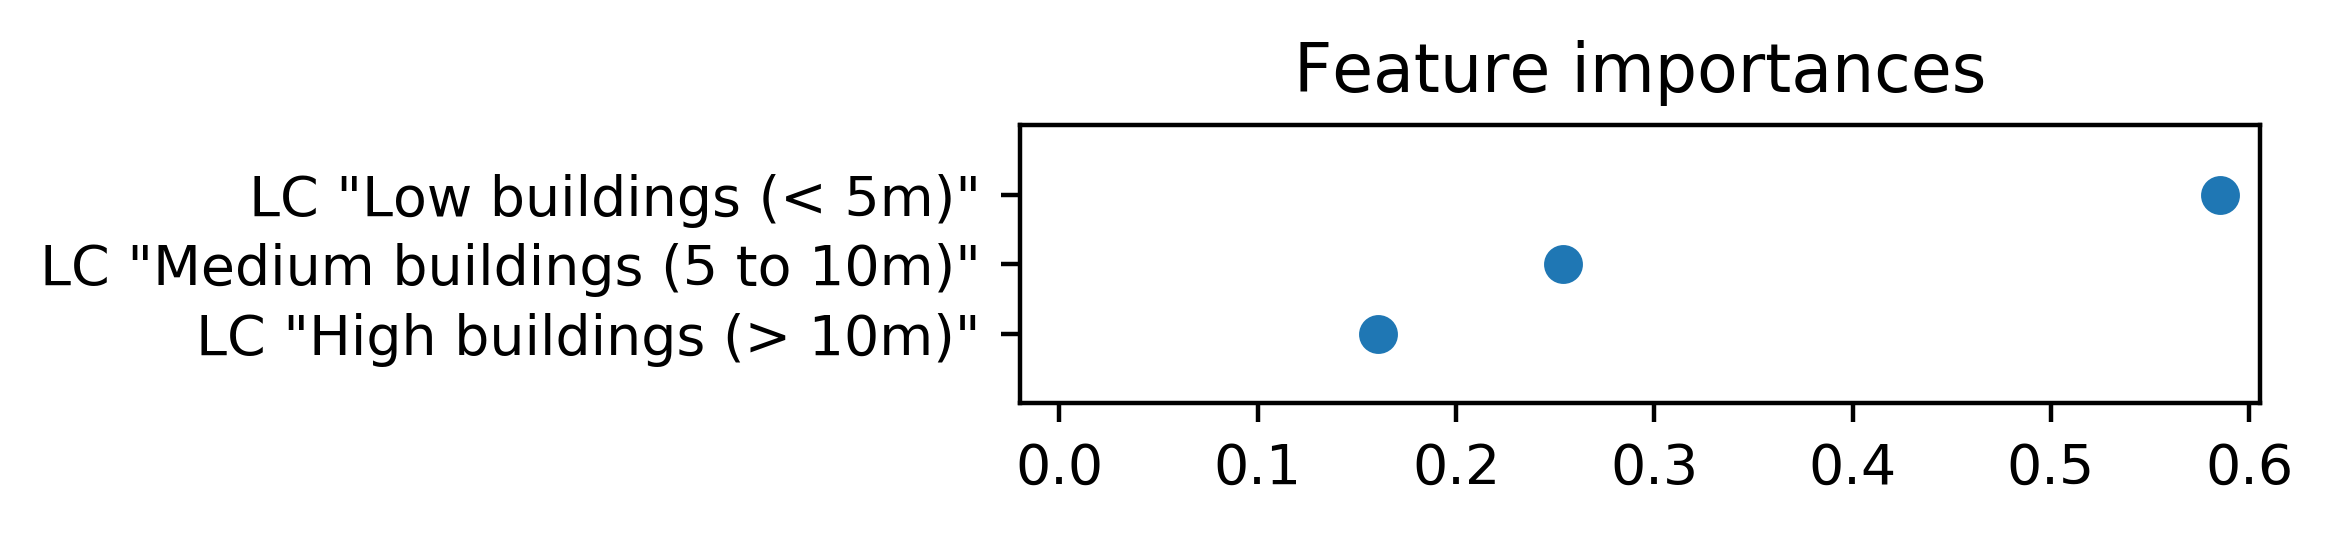

In [90]:
from IPython.display import Image 
Image(filename=feature_importance_plot, width=600)

## Test D

Here, the weights are created using RF regressor: 
- All the classes comming from the VHR land cover maps are used.
- In the predicted weight layer, grids where there is 0% of built-up (VHR 3 built classes) are forced to zero weight.

In [91]:
# Name of test
test = 'D'

# Define classes of each input layer to be used in the test (lists of values)
lc_classes = lc_classes_list  # land cover layer
lu_classes = []  # land use layer
mr_classes = []  # medium resolution built-up layer

# Name of layer that will be use to force weights to zero if absence of a built-up class 
layer_to_mask_weights = Land_cover
# Value of built-up classes in the 'layer_to_mask_weights' layer (list)
built_up_pixels = ['999']   # Class 999 correspond to all VHR built pixels

In [92]:
# Run the random forest model
function_log, feature_importance_plot = RandomForest(gridded_vector.split("@")[0],
                                                     'cat', lc_classes, lu_classes, mr_classes,
                                                     layer_to_mask_weights, built_up_pixels, test)
log_text+=function_log+'\n'  # Save the function log in the whole log of the notebook

Working of random forest model...
... starting grid search for RF hyperparameters...
... starting prediction of weights...

Creation of weighting layer...

Creation of feature importance plot...


-------------- TEST D --------------
Random Forest classifier for creating the weighting layer
VHR land cover classes used: 10, 22, 23, 33, 34, 45, 111, 112, 113 
VHR land use classes used: None 
MR built-up classe used: None 
Layer 'landcover' used to force zero weights when proportion of class '999' is null
Selected covariates for the random forest model (with feature importance upper than 0.0 %) : 
LC_10_proportion
LC_22_proportion
LC_23_proportion
LC_33_proportion
LC_34_proportion
LC_45_proportion
LC_111_proportion
LC_112_proportion
LC_113_proportion

Parameter grid for Random Forest tuning :
    max_features : sqrt, 0.05, 0.1, 0.2, 0.3
    n_estimators : 250, 350, 500, 750
    oob_score : True
    bootstrap : True

Optimized parameters for Random Forest after grid search 3-fold cross-val

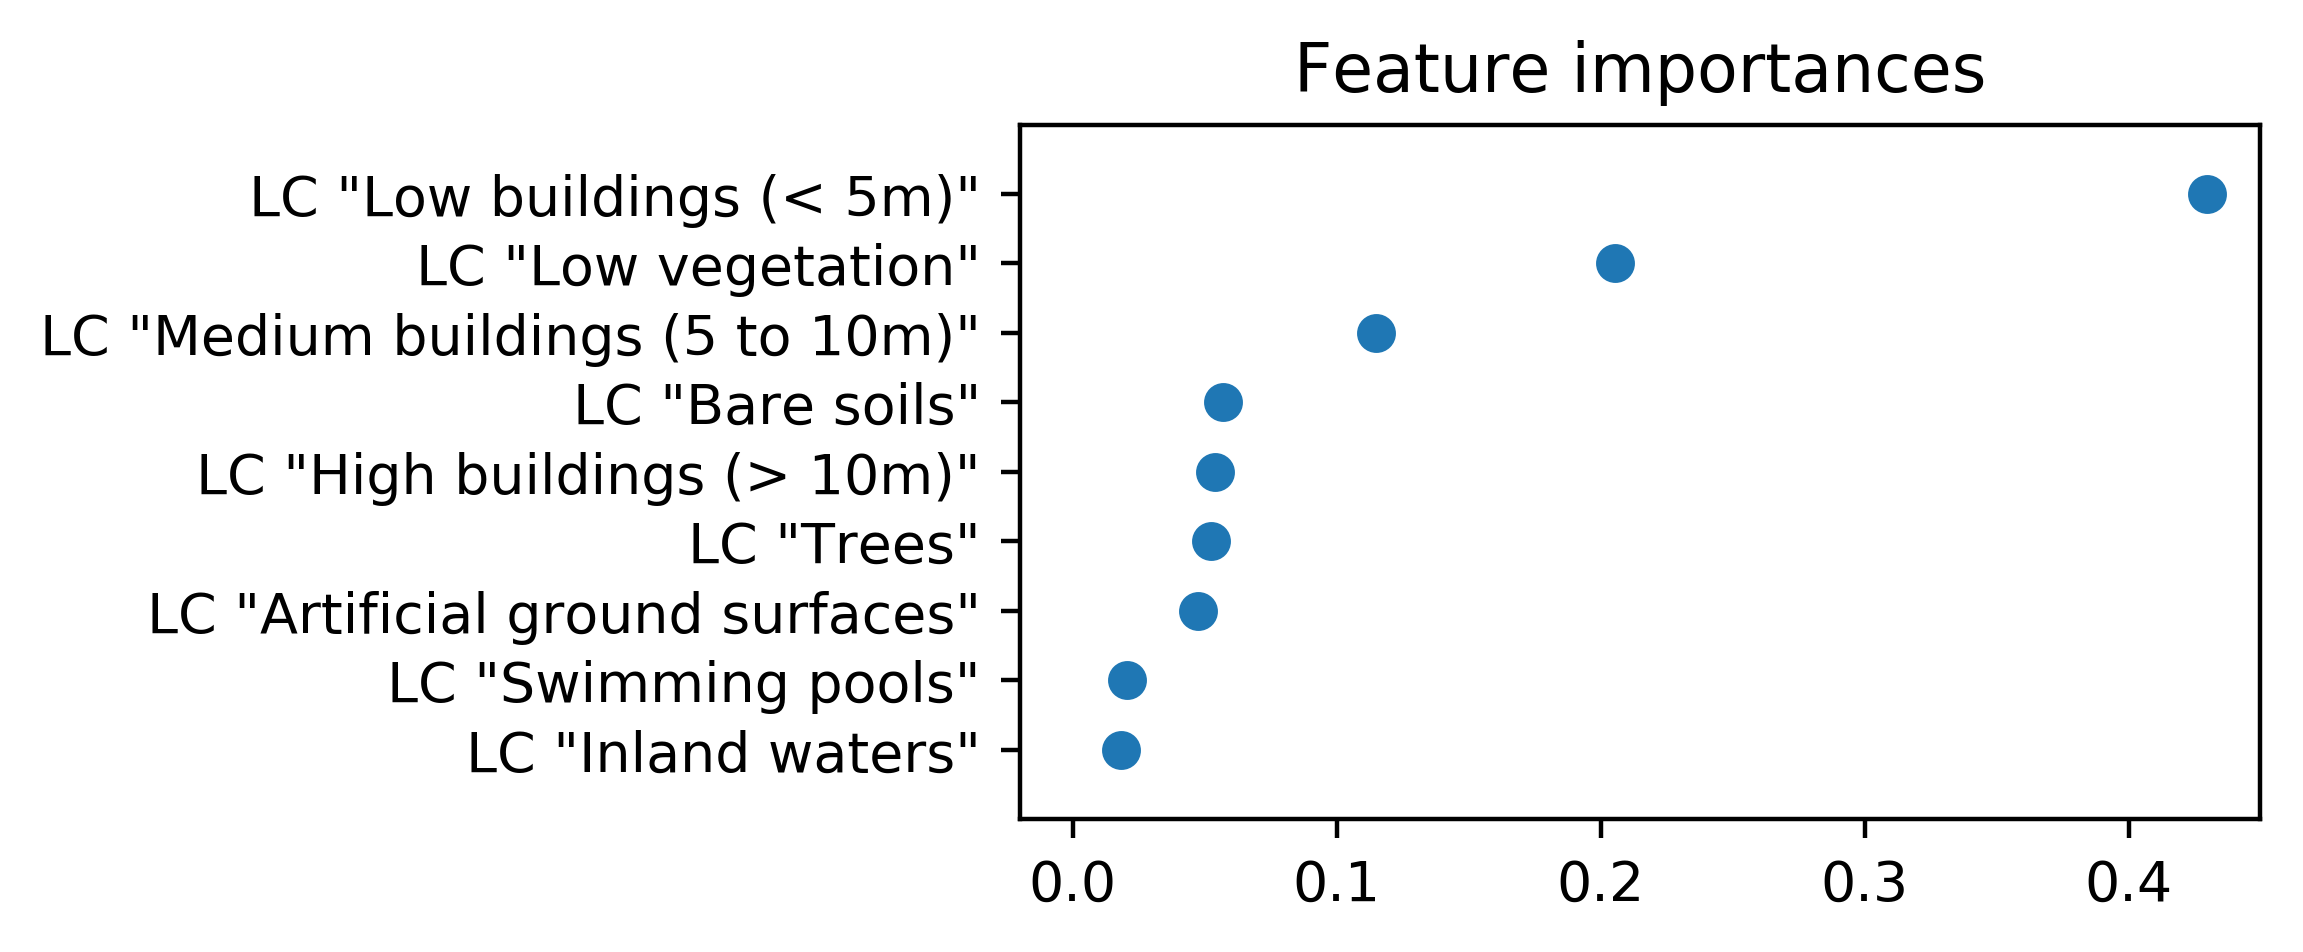

In [93]:
from IPython.display import Image 
Image(filename=feature_importance_plot, width=600)

## Test E

Here, the weights are created using RF regressor: 
- All land use classes are used. 
- In the predicted weight layer, grids where there is 0% of potentially inhabited land used classes (residential and administrative commercial and services uses, as well as uncertain use) are forced to zero weight.

In [94]:
# Name of test
test = 'E'

# Define classes of each input layer to be used in the test (lists of values)
lc_classes = []  # land cover layer
lu_classes = lu_classes_list  # land use layer
mr_classes = []  # medium resolution built-up layer

# Name of layer that will be use to force weights to zero if absence of a built-up class 
layer_to_mask_weights = Land_use
# Value of built-up classes in the 'layer_to_mask_weights' layer (list)
built_up_pixels = ['4','5','6','7','8']   

In [95]:
# Run the random forest model
function_log, feature_importance_plot = RandomForest(gridded_vector.split("@")[0],
                                                     'cat', lc_classes, lu_classes, mr_classes,
                                                     layer_to_mask_weights, built_up_pixels, test)
log_text+=function_log+'\n'  # Save the function log in the whole log of the notebook

Working of random forest model...
... starting grid search for RF hyperparameters...
... starting prediction of weights...

Creation of weighting layer...

Creation of feature importance plot...


-------------- TEST E --------------
Random Forest classifier for creating the weighting layer
VHR land cover classes used: None 
VHR land use classes used: 1, 2, 3, 4, 5, 6, 7, 8 
MR built-up classe used: None 
Layer 'landuse' used to force zero weights when proportion of class '4', '5', '6', '7', '8' is null
Selected covariates for the random forest model (with feature importance upper than 0.0 %) : 
LU_1_proportion
LU_2_proportion
LU_3_proportion
LU_4_proportion
LU_5_proportion
LU_6_proportion
LU_7_proportion
LU_8_proportion

Parameter grid for Random Forest tuning :
    max_features : sqrt, 0.05, 0.1, 0.2, 0.3
    n_estimators : 250, 350, 500, 750
    oob_score : True
    bootstrap : True

Optimized parameters for Random Forest after grid search 3-fold cross-validation tuning :
    max_fe

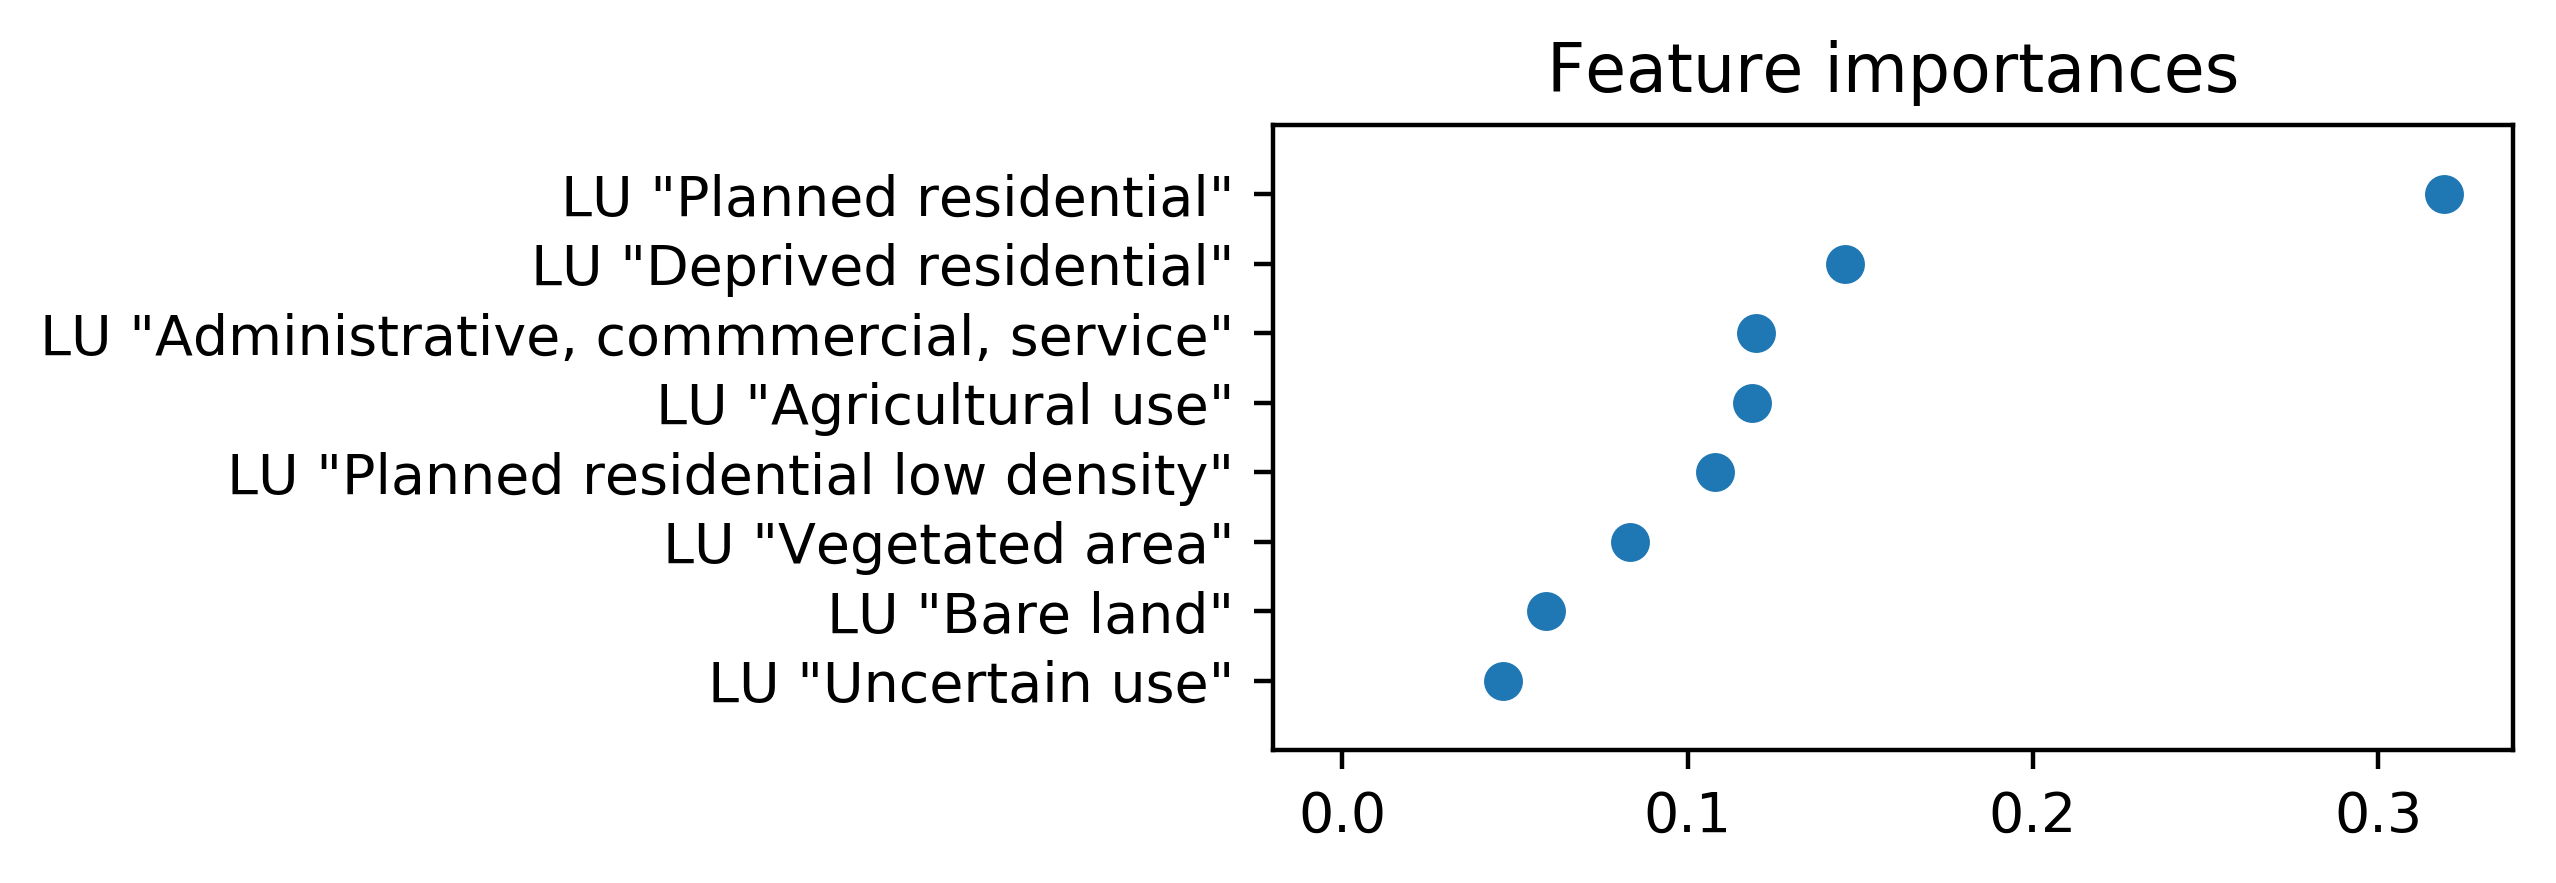

In [96]:
from IPython.display import Image 
Image(filename=feature_importance_plot, width=600)

## Test F

Here, the weights are created using RF regressor: 
- All land use classes are used. 
- The MR built-up mask is used.
- In the predicted weight layer, grids where there is 0% of built-up (MR mask) are forced to zero weight.

In [97]:
# Name of test
test = 'F'

# Define classes of each input layer to be used in the test (lists of values)
lc_classes = []  # land cover layer
lu_classes = lu_classes_list  # land use layer
mr_classes = ['1']  # medium resolution built-up layer

# Name of layer that will be use to force weights to zero if absence of a built-up class 
layer_to_mask_weights = mr_builtup
# Value of built-up classes in the 'layer_to_mask_weights' layer (list)
built_up_pixels = ['1']

In [98]:
# Run the random forest model
function_log, feature_importance_plot = RandomForest(gridded_vector.split("@")[0],
                                                     'cat', lc_classes, lu_classes, mr_classes,
                                                     layer_to_mask_weights, built_up_pixels, test)
log_text+=function_log+'\n'  # Save the function log in the whole log of the notebook

Working of random forest model...
... starting grid search for RF hyperparameters...
... starting prediction of weights...

Creation of weighting layer...

Creation of feature importance plot...


-------------- TEST F --------------
Random Forest classifier for creating the weighting layer
VHR land cover classes used: None 
VHR land use classes used: 1, 2, 3, 4, 5, 6, 7, 8 
MR built-up classe used: 1 
Layer 'MR_builtup' used to force zero weights when proportion of class '1' is null
Selected covariates for the random forest model (with feature importance upper than 0.0 %) : 
LU_1_proportion
LU_2_proportion
LU_3_proportion
LU_4_proportion
LU_5_proportion
LU_6_proportion
LU_7_proportion
LU_8_proportion
MR_1_proportion

Parameter grid for Random Forest tuning :
    max_features : sqrt, 0.05, 0.1, 0.2, 0.3
    n_estimators : 250, 350, 500, 750
    oob_score : True
    bootstrap : True

Optimized parameters for Random Forest after grid search 3-fold cross-validation tuning :
    max_featur

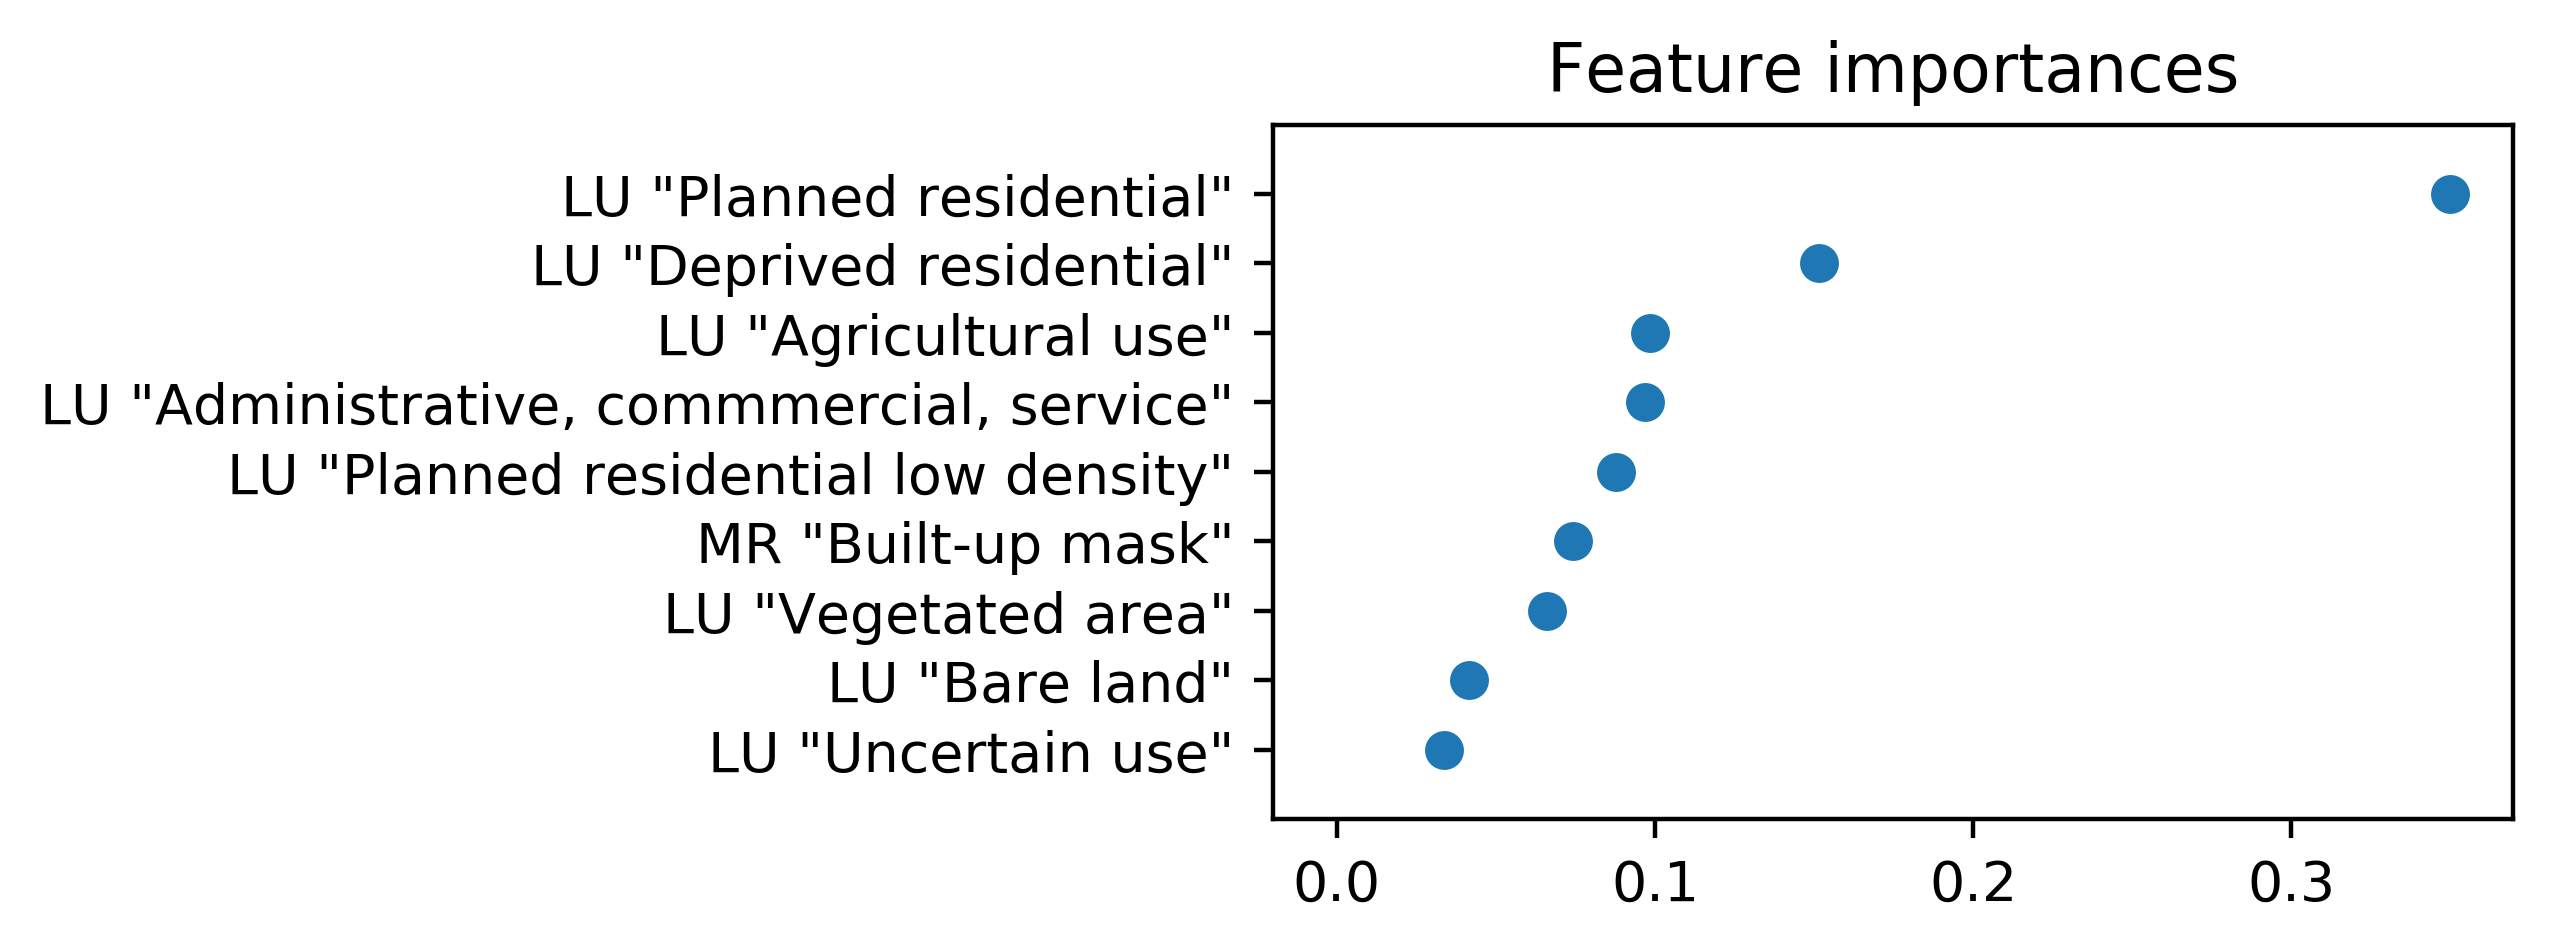

In [99]:
from IPython.display import Image 
Image(filename=feature_importance_plot, width=600)

## Test G

Here, the weights are created using RF regressor: 
- One single built class comming from the VHR land cover maps is used (binary mask built/non-built).
- All land use classes are used. 
- In the predicted weight layer, grids where there is 0% of built-up (VHR binary mask built/non-built) are forced to zero weight.

In [100]:
# Name of test
test = 'G'

# Define classes of each input layer to be used in the test (lists of values)
lc_classes = ['999']  # land cover layer
lu_classes = lu_classes_list  # land use layer
mr_classes = []  # medium resolution built-up layer

# Name of layer that will be use to force weights to zero if absence of a built-up class 
layer_to_mask_weights = Land_cover
# Value of built-up classes in the 'layer_to_mask_weights' layer (list)
built_up_pixels = ['999']

In [101]:
# Run the random forest model
function_log, feature_importance_plot = RandomForest(gridded_vector.split("@")[0],
                                                     'cat', lc_classes, lu_classes, mr_classes,
                                                     layer_to_mask_weights, built_up_pixels, test)
log_text+=function_log+'\n'  # Save the function log in the whole log of the notebook

Working of random forest model...
... starting grid search for RF hyperparameters...
... starting prediction of weights...

Creation of weighting layer...

Creation of feature importance plot...


-------------- TEST G --------------
Random Forest classifier for creating the weighting layer
VHR land cover classes used: 999 
VHR land use classes used: 1, 2, 3, 4, 5, 6, 7, 8 
MR built-up classe used: None 
Layer 'landcover' used to force zero weights when proportion of class '999' is null
Selected covariates for the random forest model (with feature importance upper than 0.0 %) : 
LC_999_proportion
LU_1_proportion
LU_2_proportion
LU_3_proportion
LU_4_proportion
LU_5_proportion
LU_6_proportion
LU_7_proportion
LU_8_proportion

Parameter grid for Random Forest tuning :
    max_features : sqrt, 0.05, 0.1, 0.2, 0.3
    n_estimators : 250, 350, 500, 750
    oob_score : True
    bootstrap : True

Optimized parameters for Random Forest after grid search 3-fold cross-validation tuning :
    max_f

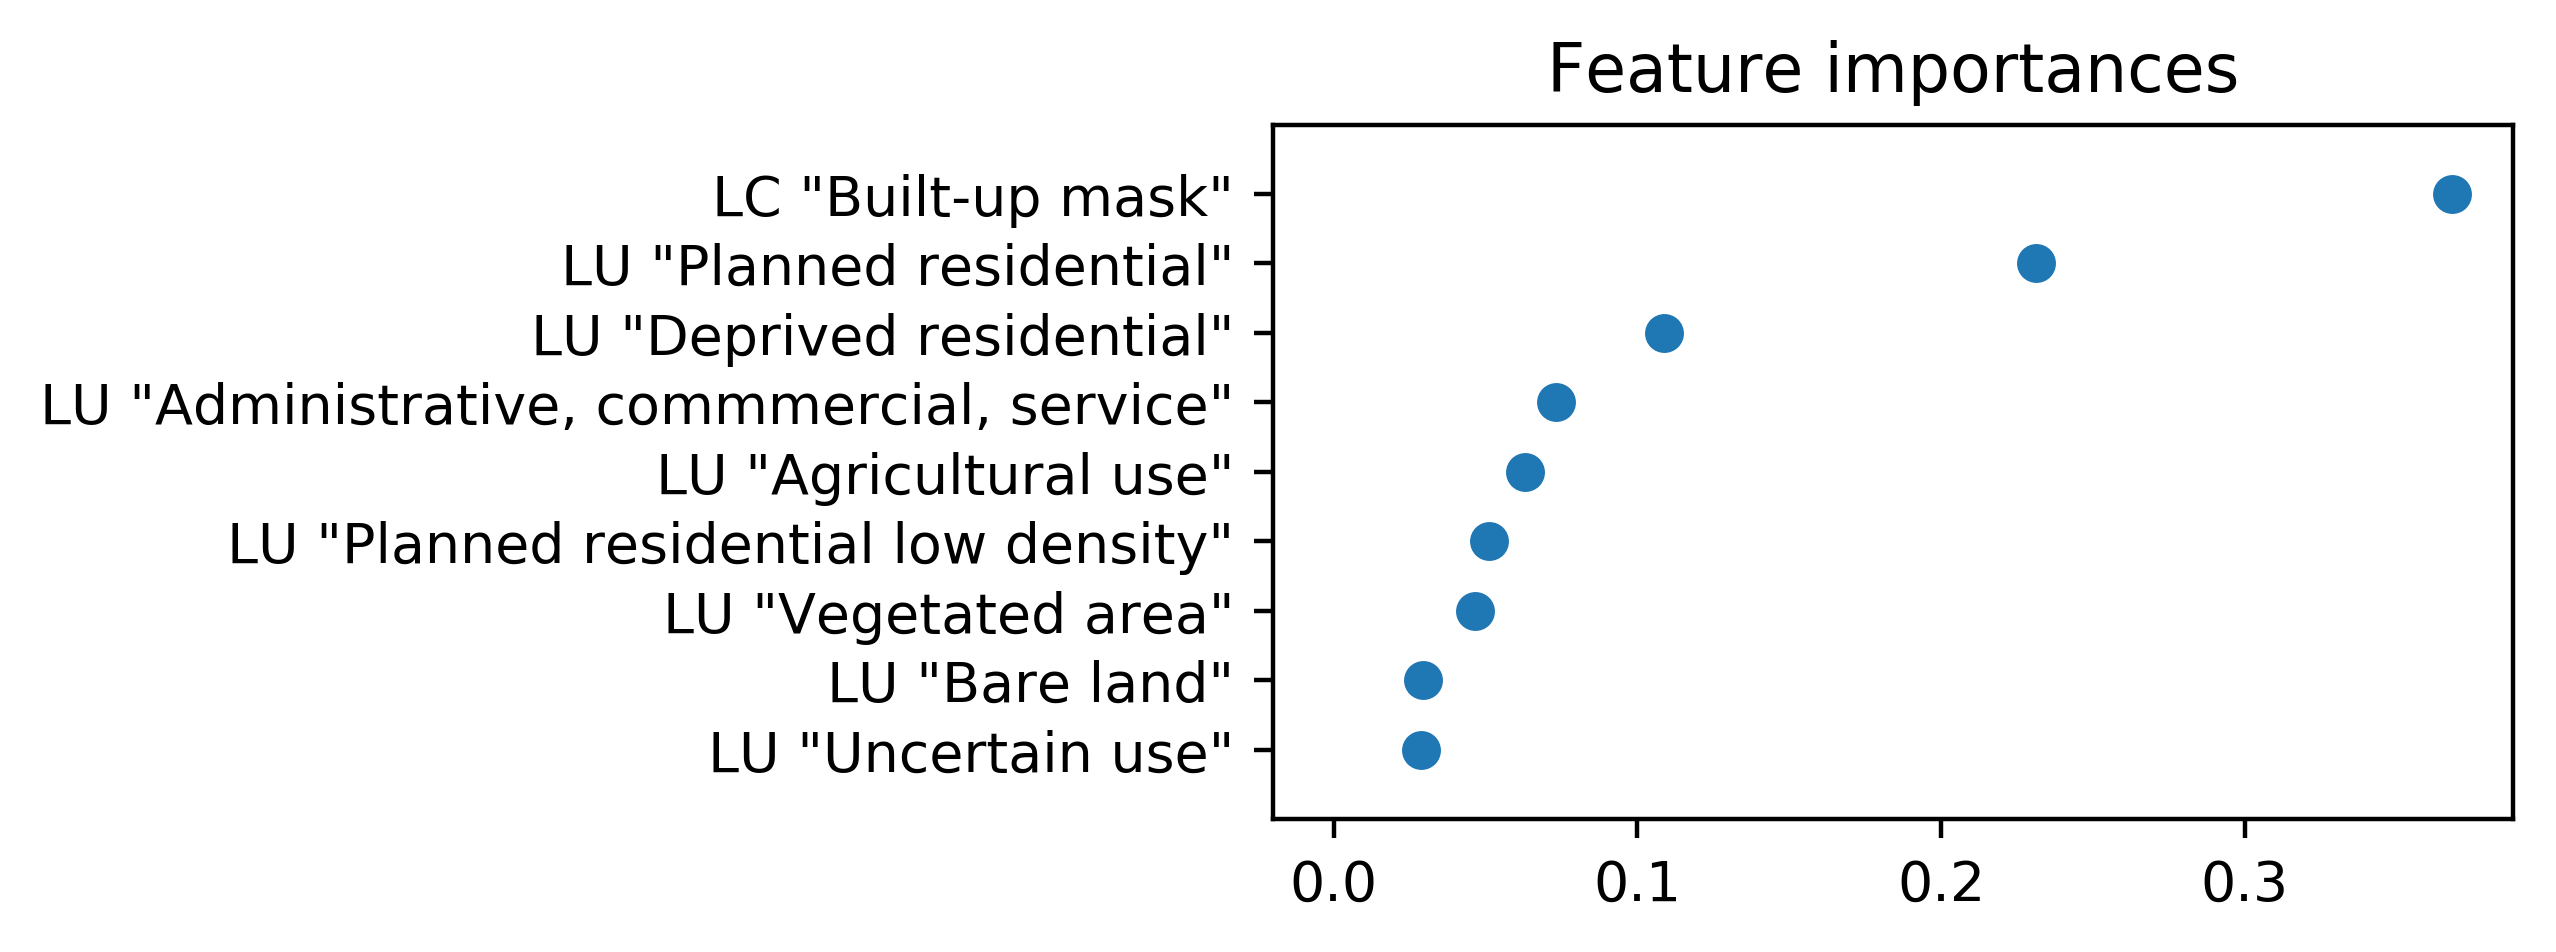

In [102]:
from IPython.display import Image 
Image(filename=feature_importance_plot, width=600)

## Test H

Here, the weights are created using RF regressor: 
- The three different classes of built-up comming from the VHR land cover maps are used (low-elevated built-up, medium-elevated built-up, high-elevated built-up).
- All land use classes are used. 
- In the predicted weight layer, grids where there is 0% of built-up (VHR 3 built classes) are forced to zero weight.

In [103]:
# Name of test
test = 'H'

# Define classes of each input layer to be used in the test (lists of values)
lc_classes = ['111','112','113']  # land cover layer
lu_classes = lu_classes_list  # land use layer
mr_classes = []  # medium resolution built-up layer

# Name of layer that will be use to force weights to zero if absence of a built-up class 
layer_to_mask_weights = Land_cover
# Value of built-up classes in the 'layer_to_mask_weights' layer (list)
built_up_pixels = ['999']   # Class 999 correspond to all VHR built pixels

In [104]:
# Run the random forest model
function_log, feature_importance_plot = RandomForest(gridded_vector.split("@")[0],
                                                     'cat', lc_classes, lu_classes, mr_classes,
                                                     layer_to_mask_weights, built_up_pixels, test)
log_text+=function_log+'\n'  # Save the function log in the whole log of the notebook

Working of random forest model...
... starting grid search for RF hyperparameters...
... starting prediction of weights...

Creation of weighting layer...

Creation of feature importance plot...


-------------- TEST H --------------
Random Forest classifier for creating the weighting layer
VHR land cover classes used: 111, 112, 113 
VHR land use classes used: 1, 2, 3, 4, 5, 6, 7, 8 
MR built-up classe used: None 
Layer 'landcover' used to force zero weights when proportion of class '999' is null
Selected covariates for the random forest model (with feature importance upper than 0.0 %) : 
LC_111_proportion
LC_112_proportion
LC_113_proportion
LU_1_proportion
LU_2_proportion
LU_3_proportion
LU_4_proportion
LU_5_proportion
LU_6_proportion
LU_7_proportion
LU_8_proportion

Parameter grid for Random Forest tuning :
    max_features : sqrt, 0.05, 0.1, 0.2, 0.3
    n_estimators : 250, 350, 500, 750
    oob_score : True
    bootstrap : True

Optimized parameters for Random Forest after grid sea

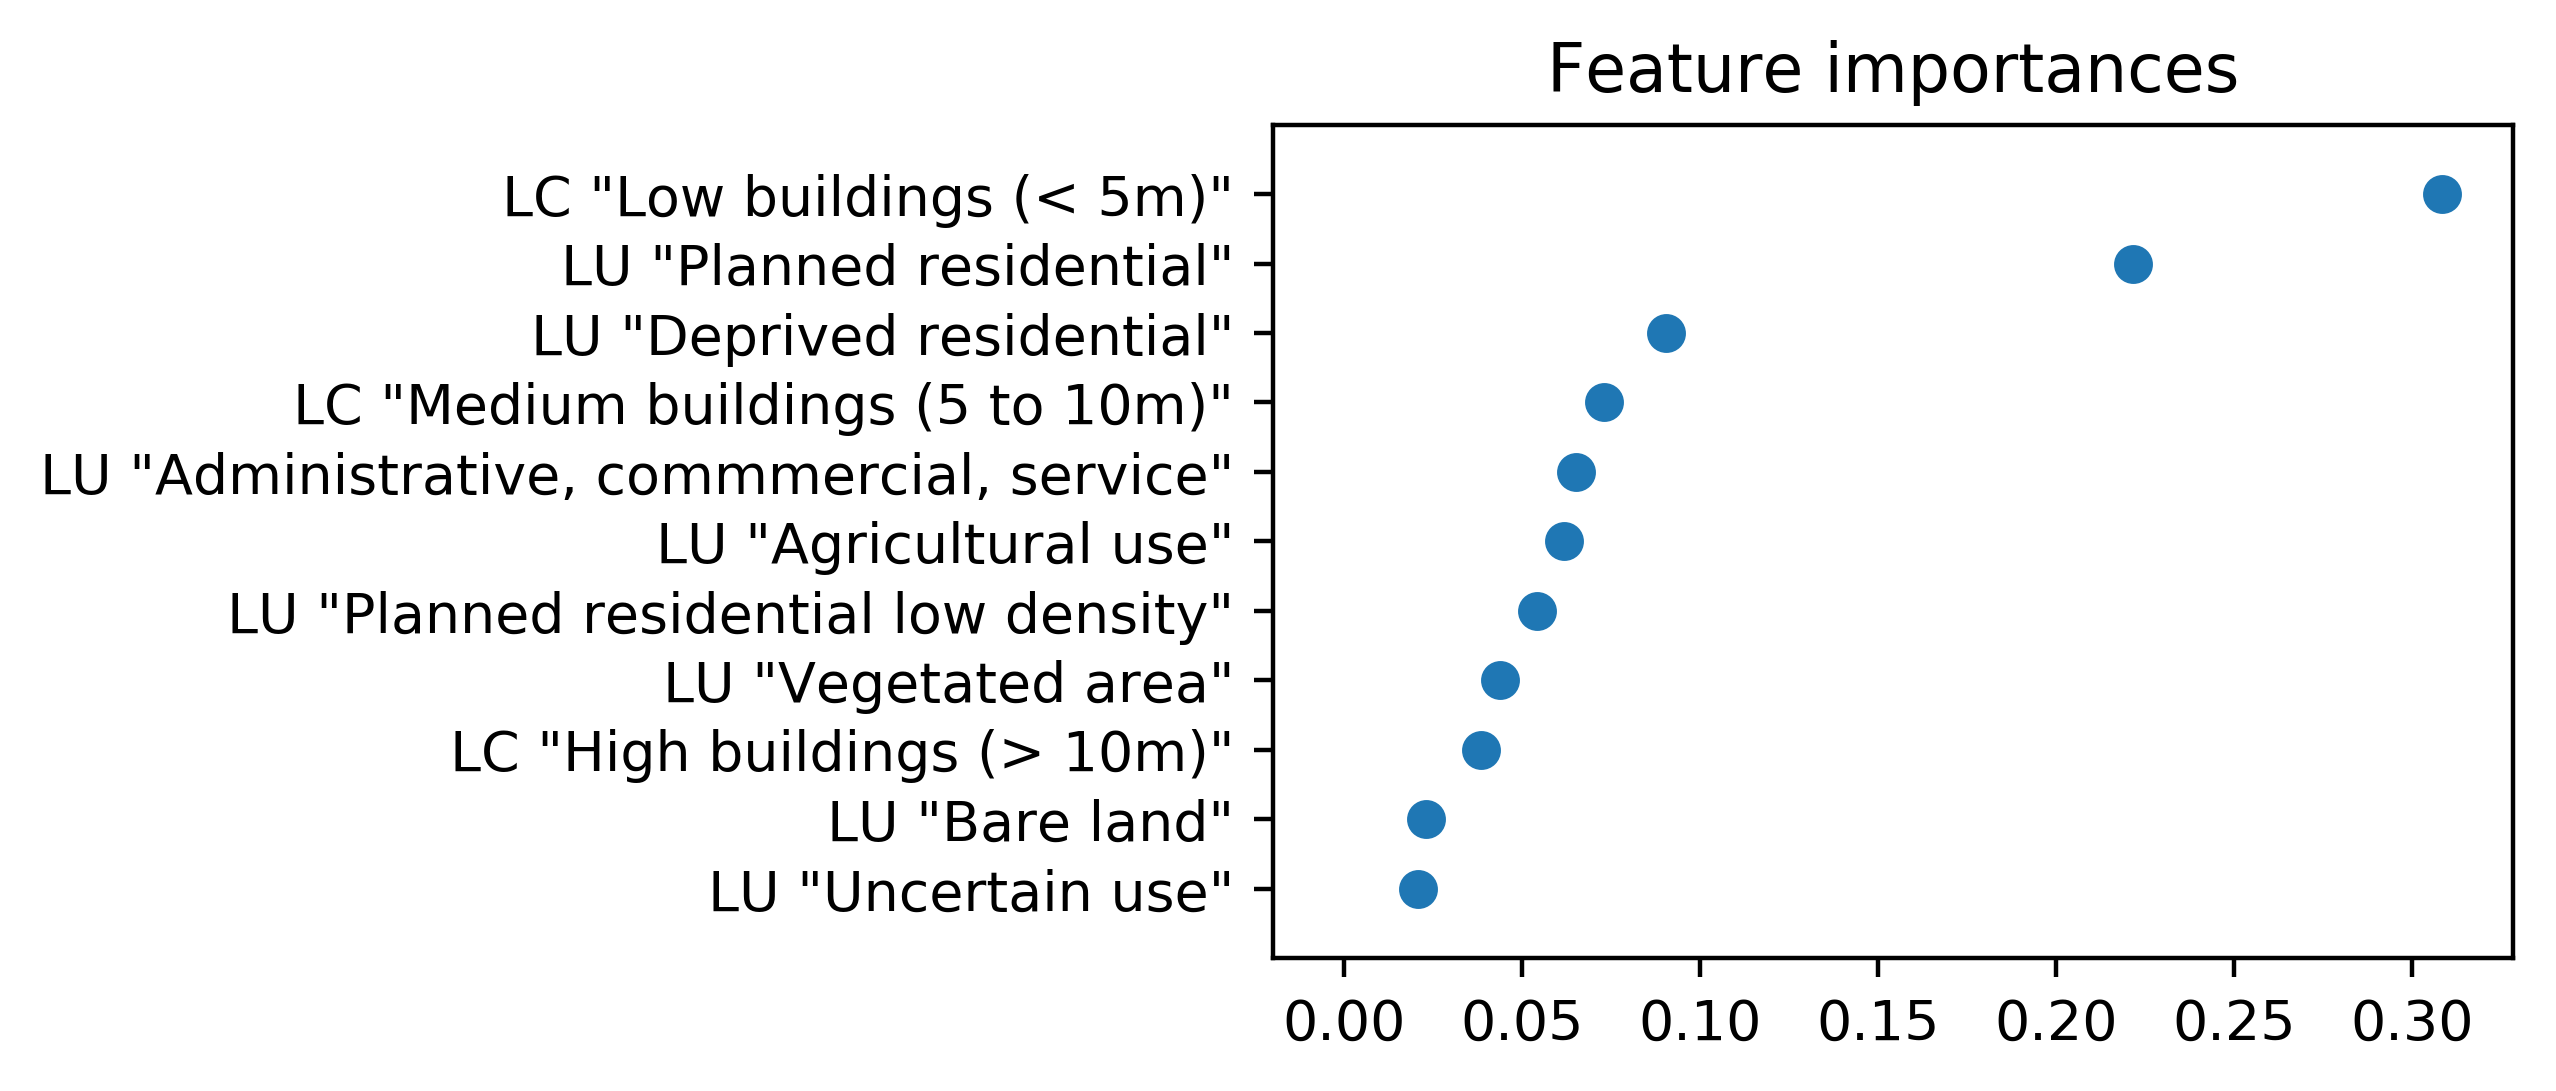

In [105]:
from IPython.display import Image 
Image(filename=feature_importance_plot, width=600)

## Test I

Here, the weights are created using RF regressor: 
- All the classes comming from the VHR land cover maps are used.
- All land use classes are used. 
- In the predicted weight layer, grids where there is 0% of built-up (VHR 3 built classes) are forced to zero weight.

In [106]:
# Name of test
test = 'I'

# Define classes of each input layer to be used in the test (lists of values)
lc_classes = lc_classes_list  # land cover layer
lu_classes = lu_classes_list  # land use layer
mr_classes = []  # medium resolution built-up layer

# Name of layer that will be use to force weights to zero if absence of a built-up class 
layer_to_mask_weights = Land_cover
# Value of built-up classes in the 'layer_to_mask_weights' layer (list)
built_up_pixels = ['999']   # Class 999 correspond to all VHR built pixels

In [107]:
# Run the random forest model
function_log, feature_importance_plot = RandomForest(gridded_vector.split("@")[0],
                                                     'cat', lc_classes, lu_classes, mr_classes,
                                                     layer_to_mask_weights, built_up_pixels, test)
log_text+=function_log+'\n'  # Save the function log in the whole log of the notebook

Working of random forest model...
... starting grid search for RF hyperparameters...
... starting prediction of weights...

Creation of weighting layer...

Creation of feature importance plot...


-------------- TEST I --------------
Random Forest classifier for creating the weighting layer
VHR land cover classes used: 10, 22, 23, 33, 34, 45, 111, 112, 113 
VHR land use classes used: 1, 2, 3, 4, 5, 6, 7, 8 
MR built-up classe used: None 
Layer 'landcover' used to force zero weights when proportion of class '999' is null
Selected covariates for the random forest model (with feature importance upper than 0.0 %) : 
LC_10_proportion
LC_22_proportion
LC_23_proportion
LC_33_proportion
LC_34_proportion
LC_45_proportion
LC_111_proportion
LC_112_proportion
LC_113_proportion
LU_1_proportion
LU_2_proportion
LU_3_proportion
LU_4_proportion
LU_5_proportion
LU_6_proportion
LU_7_proportion
LU_8_proportion

Parameter grid for Random Forest tuning :
    max_features : sqrt, 0.05, 0.1, 0.2, 0.3
    n_es

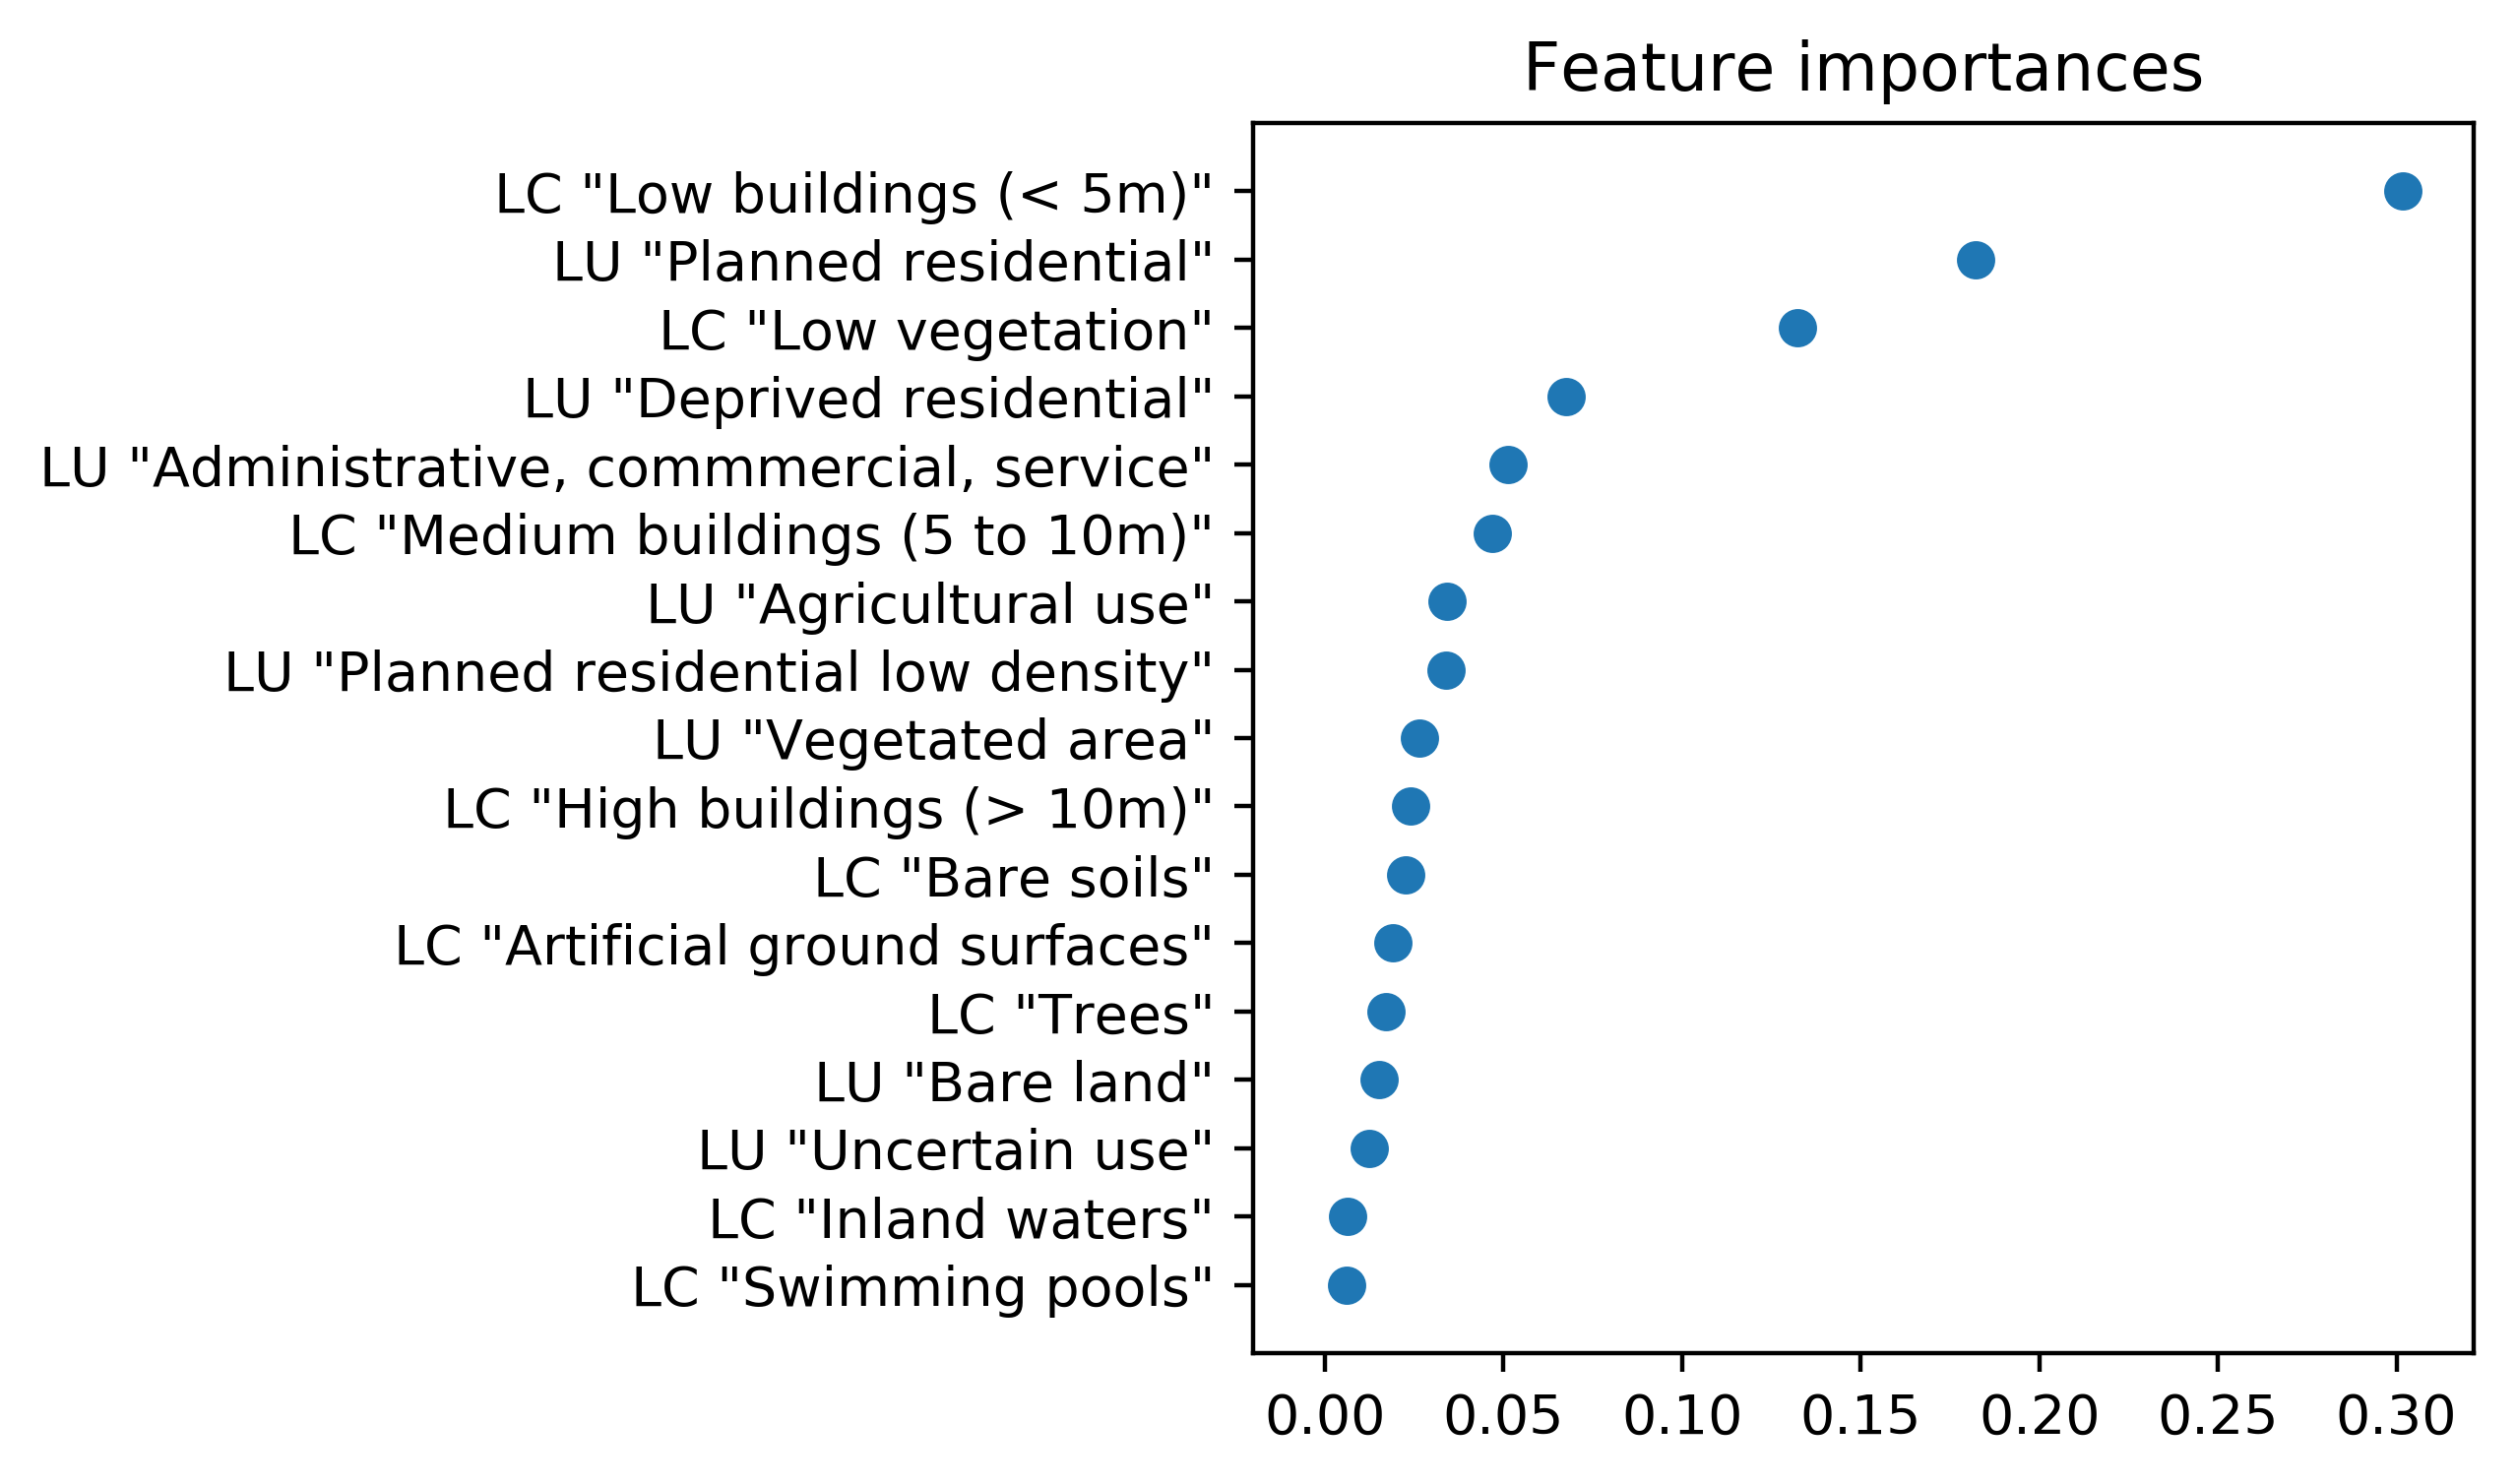

In [108]:
from IPython.display import Image 
Image(filename=feature_importance_plot, width=600)

## Test J

Here, the weights are created using RF regressor: 
- All the classes comming from the VHR land cover maps are used.
- All land use classes are used. 
- The MR built-up mask is used.
- In the predicted weight layer, grids where there is 0% of built-up (VHR 3 built classes) are forced to zero weight.

In [109]:
# Name of test
test = 'J'

# Define classes of each input layer to be used in the test (lists of values)
lc_classes = lc_classes_list  # land cover layer
lu_classes = lu_classes_list  # land use layer
mr_classes = ['1']  # medium resolution built-up layer

# Name of layer that will be use to force weights to zero if absence of a built-up class 
layer_to_mask_weights = Land_cover
# Value of built-up classes in the 'layer_to_mask_weights' layer (list)
built_up_pixels = ['999']   # Class 999 correspond to all VHR built pixels

In [110]:
# Run the random forest model
function_log, feature_importance_plot = RandomForest(gridded_vector.split("@")[0],
                                                     'cat', lc_classes, lu_classes, mr_classes,
                                                     layer_to_mask_weights, built_up_pixels, test)
log_text+=function_log+'\n'  # Save the function log in the whole log of the notebook

Working of random forest model...
... starting grid search for RF hyperparameters...
... starting prediction of weights...

Creation of weighting layer...

Creation of feature importance plot...


-------------- TEST J --------------
Random Forest classifier for creating the weighting layer
VHR land cover classes used: 10, 22, 23, 33, 34, 45, 111, 112, 113 
VHR land use classes used: 1, 2, 3, 4, 5, 6, 7, 8 
MR built-up classe used: 1 
Layer 'landcover' used to force zero weights when proportion of class '999' is null
Selected covariates for the random forest model (with feature importance upper than 0.0 %) : 
LC_10_proportion
LC_22_proportion
LC_23_proportion
LC_33_proportion
LC_34_proportion
LC_45_proportion
LC_111_proportion
LC_112_proportion
LC_113_proportion
LU_1_proportion
LU_2_proportion
LU_3_proportion
LU_4_proportion
LU_5_proportion
LU_6_proportion
LU_7_proportion
LU_8_proportion
MR_1_proportion

Parameter grid for Random Forest tuning :
    max_features : sqrt, 0.05, 0.1, 0.2,

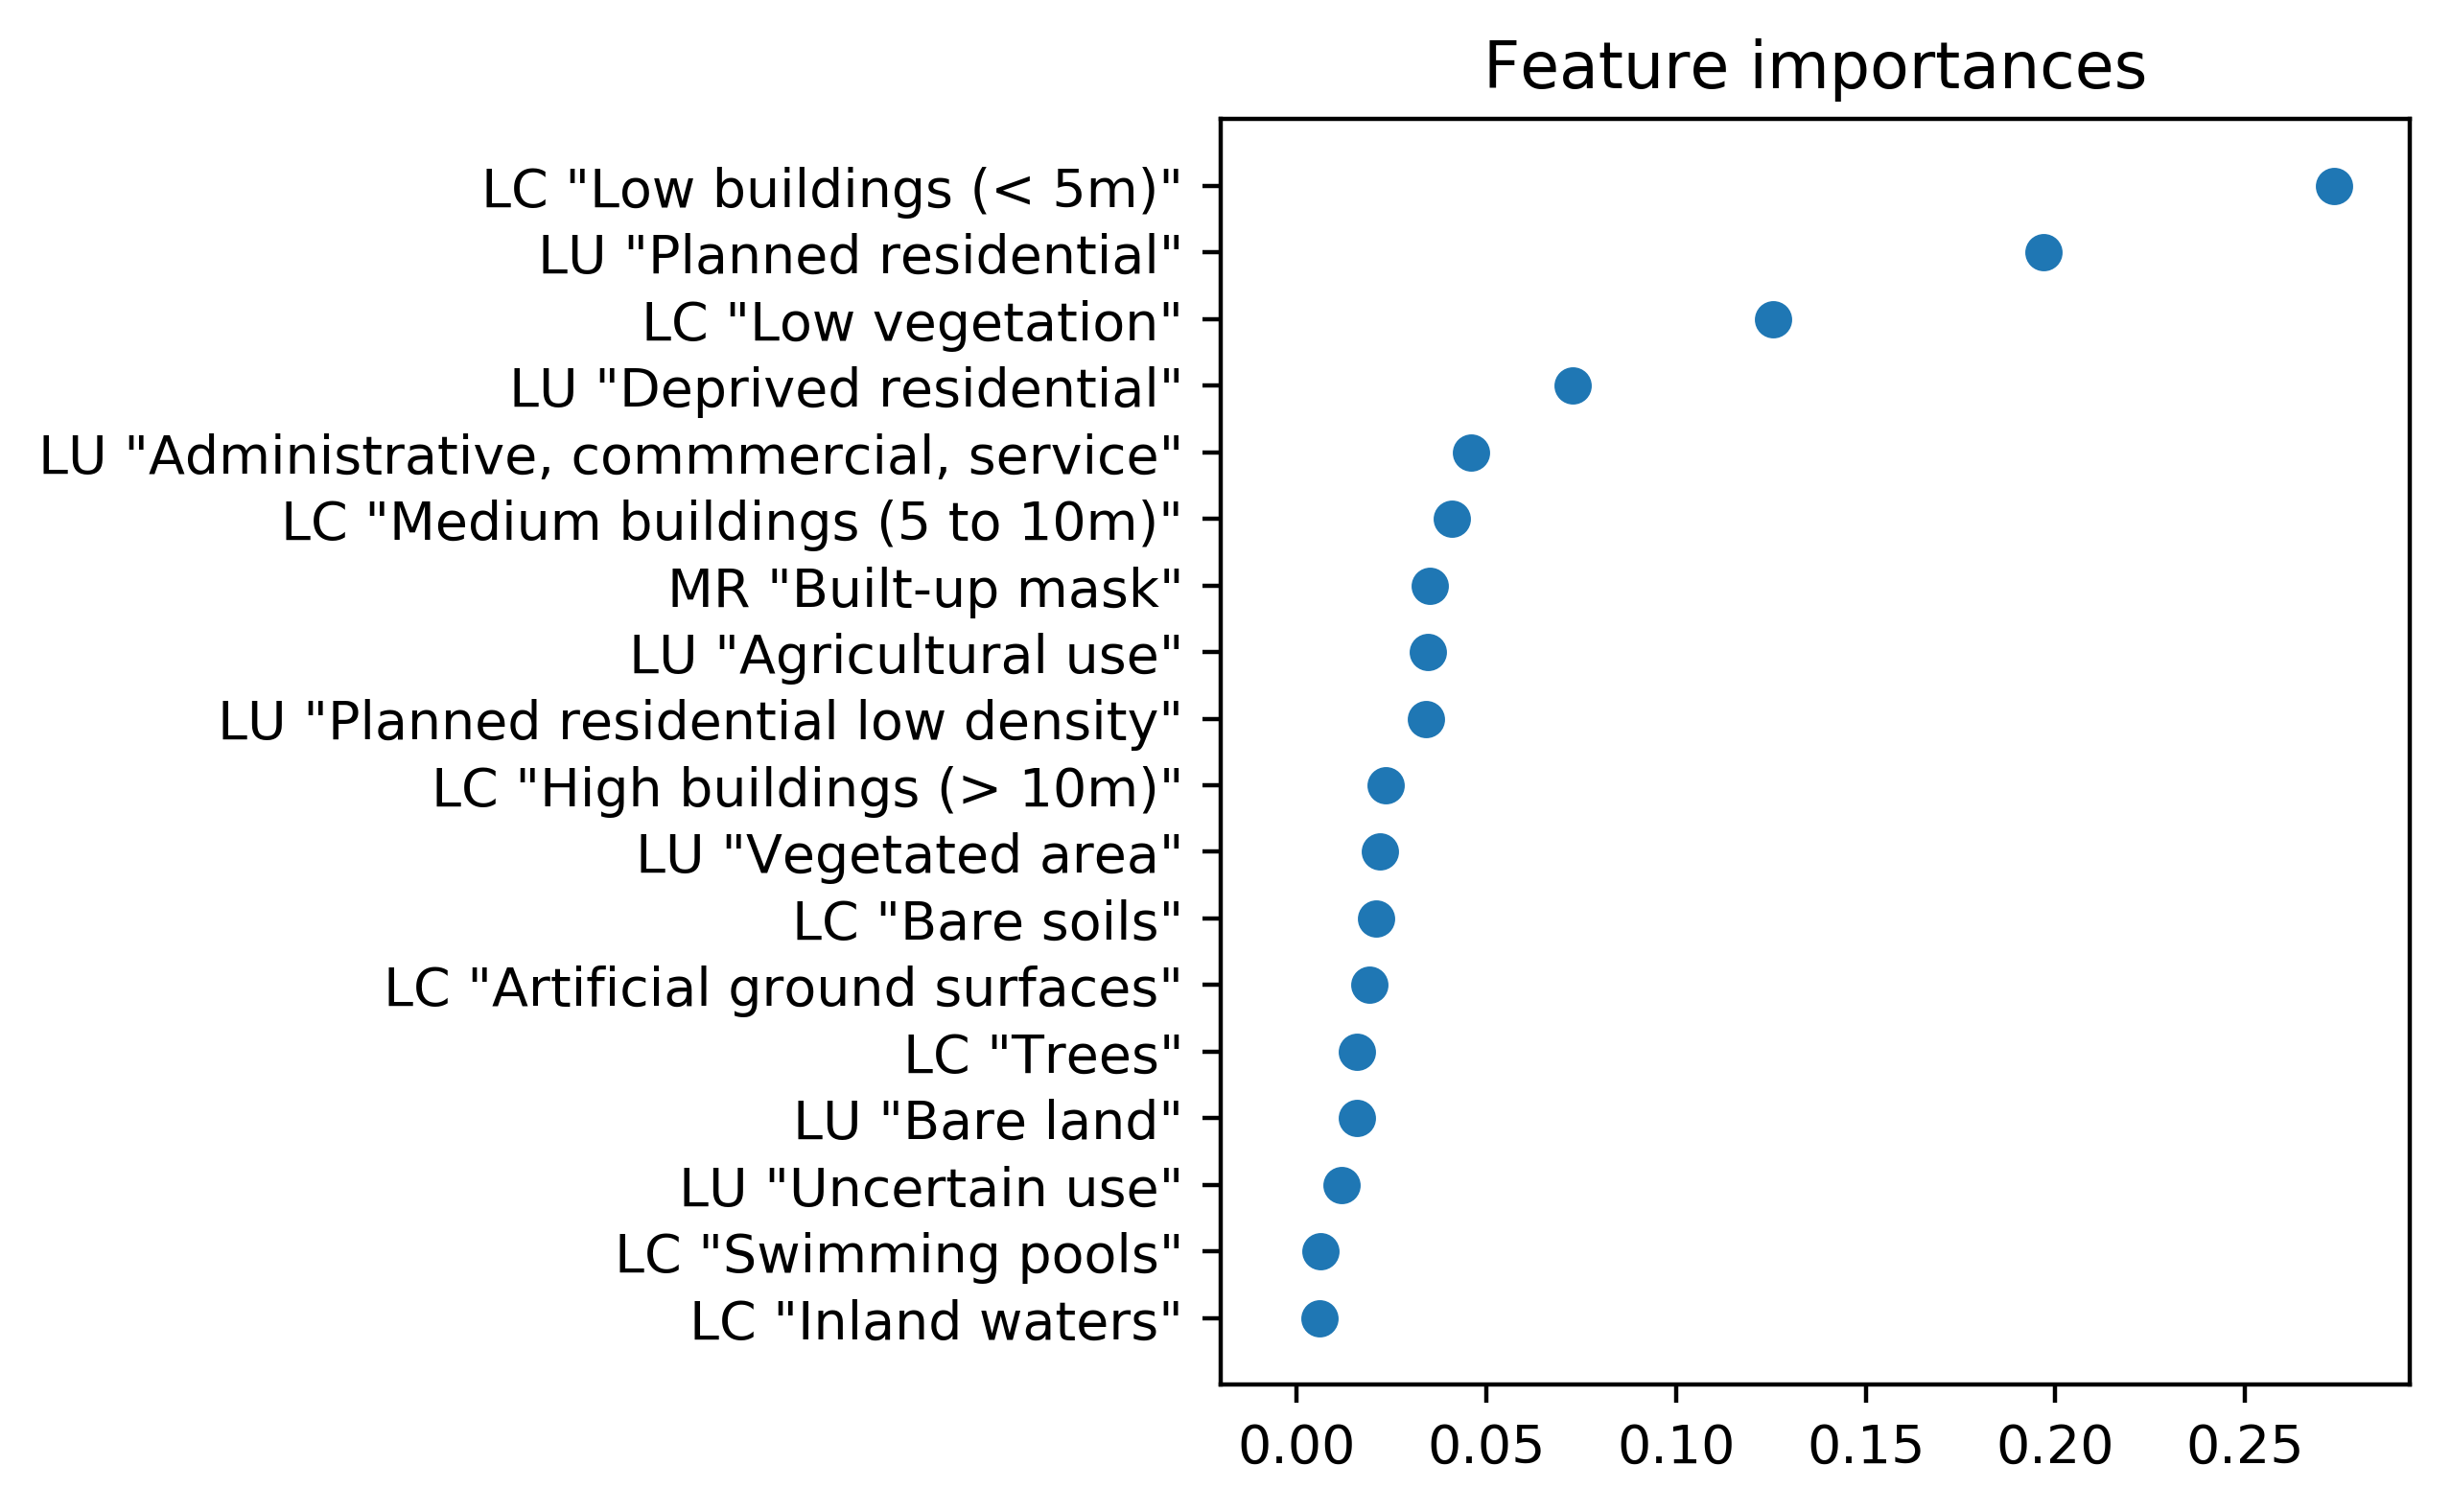

In [111]:
from IPython.display import Image 
Image(filename=feature_importance_plot, width=600)

# Reallocate the population count using weighting layer

In [112]:
# Name of the layer containing the population count to disagregate
print "Vector layer containing the variable to disagregate : '%s'"%gridded_vector
print "Attribute column containing the variable : '%s'"%population_column

Vector layer containing the variable to disagregate : 'admin_level1_100m_gridded'
Attribute column containing the variable : 'POPULATION'


In [113]:
# Export weighing layers
for test in ['0','A','B','C','D','E','F','G','H','I','J']:
    outputfolder = os.path.join(outputdirectory_results,"Test_%s"%test)
    if not os.path.exists(outputfolder):  #Create folder where to save the plot if not exists
        os.makedirs(outputfolder)
    weight_raster = "Test_%s_weight"%test
    predict_raster = "Test_%s_prediction"%test   
    gscript.run_command('v.area.weigh', overwrite=True, quiet=True, vector=gridded_vector, 
                        column=population_column, weight=weight_raster, output=predict_raster)

# Export log file

In [114]:
## Export the log file
logging=open(os.path.join(outputdirectory_results,'logfile.txt'), 'w')
logging.write(log_text)
logging.close()

In [115]:
print log_text

Classes of raster 'landcover': 10,22,23,33,34,45,111,112,113
Classes of raster 'landuse': 1,2,3,4,5,6,7,8

-------------- TEST 0 --------------
Randomly generated weighting layer 


-------------- TEST A --------------
Simple weighting layer (not RF) based on 'MR_1_proportion' 


-------------- TEST B --------------
Simple weighting layer (not RF) based on 'LC_999_proportion' 


-------------- TEST 0 --------------
Randomly generated weighting layer 


-------------- TEST A --------------
Simple weighting layer (not RF) based on 'MR_1_proportion' 


-------------- TEST B --------------
Simple weighting layer (not RF) based on 'LC_999_proportion' 


-------------- TEST C --------------
Random Forest classifier for creating the weighting layer
VHR land cover classes used: 111, 112, 113 
VHR land use classes used: None 
MR built-up classe used: None 
Layer 'landcover' used to force zero weights when proportion of class '999' is null
Selected covariates for the random forest model (with fe

# Export layers for archive or visualisation in another GIS

## Weighting (RF output) and prediction layer - (all tests)

In [116]:
# Export weighing layers
for test in ['0','A','B','C','D','E','F','G','H','I','J']:
    output_folder = os.path.join(outputdirectory_results,"Test_%s"%test)
    if not os.path.exists(output_folder): os.makedirs(output_folder)  #Create folder if not exists
    layer = "Test_%s_weight"%test
    output_file = os.path.join(output_folder,layer+'.tiff')
    gscript.run_command('r.out.gdal', overwrite=True, input=layer, 
                        output=output_file, format='GTiff', createopt='COMPRESS=DEFLATE')
    layer = "Test_%s_prediction"%test 
    output_file = os.path.join(output_folder,layer+'.tiff')
    gscript.run_command('r.out.gdal', overwrite=True, input=layer, 
                        output=output_file, format='GTiff', createopt='COMPRESS=DEFLATE')

# Cleaning mapset

In [117]:
print "Cleaning mapset from temporary layers..."
for raster_layer in TMP_MAPS:
    gscript.run_command('g.remove', flags='f', type='raster', name=raster_layer)

Cleaning mapset from temporary layers...
